In [1]:
import os
import sys
p = '..'
while not os.path.isdir(p + '/notebooks'):
    p += '/..'
sys.path.append(p) # for import src

import os
import cloudpickle
import lzma
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_predict
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import lightgbm as lgb
import talib
import joblib

import src
from src.ml_utils import (
    fetch_ohlcv, 
    visualize_result, 
    normalize_position, 
    calc_position_cv2,
    get_feature_columns,
    get_symbols,
    unbiased_rank,
    ewm_finite,
)
from src.data_fetcher import DataFetcher
cloudpickle.register_pickle_by_value(src) # for model portability

os.environ["USE_JOBLIB_MEMORY"] = "1"

def get_joblib_memory():
    if os.getenv('USE_JOBLIB_MEMORY'):
        return joblib.Memory('/tmp/alphapool_joblib_memory', verbose=0)
    else:
        return joblib.Memory(None, verbose=0)

model_name = '20221018_btc_one_cnn'

In [2]:
# symbols = os.getenv('ALPHAPOOL_SYMBOLS').split(',') # 売買代金が多く、古いもの
# symbols += 'DOGE,SFP,DYDX,AXS,CHZ,TRX,MASK,ETC,LTC,1000SHIB,C98,SAND,SUSHI,NEAR,FIL'.split(',')
# symbols += 'SFP,DYDX,AXS,TRX,MASK,ETC,LTC,1000SHIB,C98,SAND,SUSHI,NEAR,FIL'.split(',')
symbols = ['ADA', 'ATOM', 'BTC', 'DOT', 'ETH', 'LINK', 'MATIC', 'XRP', 'ETC', 'LTC'] # binance, bybit, okex
# symbols = ['ADA', 'ATOM', 'BNB', 'BTC', 'DOT', 'ETH', 'LINK', 'MATIC', 'XRP', 'ETC', 'LTC'] # binance, bybit
# symbols = ['ADA', 'ATOM', 'BNB', 'BTC', 'DOT', 'ETH', 'LINK', 'MATIC', 'XRP'] # binance, bybit

provider_configs = [
    {
        'provider': 'bigquery',
        'options': {
            'table': 'binance_ohlcv',
            'symbols': ['{}USDT'.format(x) for x in symbols],
        }
    },
]

dfs = DataFetcher(memory=get_joblib_memory()).fetch(
    provider_configs=provider_configs, 
    min_timestamp=None,
)

for df in dfs:
    display(df)

def merge_data(dfs):
    df = dfs[0]
    df['symbol'] = df['symbol'].str.replace('USDT', '')
    df = df.set_index(['timestamp', 'symbol']).sort_index()
    return df

df = merge_data(dfs)

def merge_kraken_data(df):
    symbols = list(df.index.get_level_values('symbol').unique())
    
    train_provider_configs = [
        {
            'provider': 'bigquery',
            'options': {
                'table': 'kraken_historical_ohlcvt',
                'symbols': symbols,
            }
        },
    ]

    dfs = DataFetcher(memory=get_joblib_memory()).fetch(
        provider_configs=train_provider_configs, 
        min_timestamp=None,
    )
    df_kraken = dfs[0].set_index(['timestamp', 'symbol'])

    df = df.copy()
    df['extended'] = False
    df = pd.concat([df, df_kraken])
    df['extended'] = df['extended'].fillna(True)
    df = df[['op', 'hi', 'lo', 'cl', 'volume', 'twap_5m', 'extended']]
    df = df.loc[~df.index.duplicated()]
    df = df.sort_index()
    return df.copy()

df = merge_kraken_data(df)

df = df.dropna()
df.to_pickle('/tmp/df_binance_ohlcv_extended.pkl')
display(df)

,timestamp,symbol,op,hi,lo,cl,volume,amount,trades,buy_volume,...,twap,twap_5m,cl_std,cl_diff_std,hi_twap,lo_twap,hi_op_max,lo_op_min,ln_hi_lo_mean,ln_hi_lo_sqr_mean
0,2021-07-07 11:00:00+00:00,ADAUSDT,1.4206,1.4330,1.4170,1.4300,14548171.0,2.077201e+07,43515.0,7770863.0,...,1.427578,1.428275,0.003467,0.001119,1.428347,1.426760,0.000923,-0.000663,0.001112,0.000002
1,2021-06-20 11:00:00+00:00,ADAUSDT,1.3476,1.3533,1.3260,1.3293,38181143.0,5.110403e+07,87818.0,18535250.0,...,1.338757,1.337625,0.006228,0.003071,1.341067,1.336997,0.001983,-0.002087,0.003039,0.000011
2,2021-06-19 23:00:00+00:00,ADAUSDT,1.3910,1.4018,1.3821,1.3829,15747336.0,2.191540e+07,54828.0,7464234.0,...,1.391135,1.391458,0.004761,0.001728,1.392305,1.390117,0.001062,-0.001127,0.001573,0.000003
3,2021-06-25 09:00:00+00:00,ADAUSDT,1.3398,1.3570,1.3230,1.3289,37778606.0,5.060536e+07,79282.0,19752438.0,...,1.340072,1.341042,0.009537,0.002410,1.342172,1.338507,0.001910,-0.001755,0.002736,0.000009
4,2021-06-11 12:00:00+00:00,ADAUSDT,1.5176,1.5199,1.5039,1.5108,16425309.0,2.482271e+07,61590.0,7741869.0,...,1.511205,1.511150,0.002715,0.001816,1.512712,1.510028,0.001377,-0.001307,0.001776,0.000003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
241655,2022-01-06 01:00:00+00:00,MATICUSDT,2.2040,2.2090,2.1450,2.1658,13881959.0,3.026007e+07,48277.0,6040660.0,...,2.183553,2.182717,0.012705,0.004017,2.186607,2.180752,0.002413,-0.003441,0.002683,0.000008
241656,2022-01-02 22:00:00+00:00,MATICUSDT,2.5123,2.5345,2.5113,2.5303,4489515.0,1.133739e+07,23375.0,2343854.0,...,2.526055,2.526575,0.004697,0.001549,2.526978,2.524592,0.001218,-0.001168,0.000945,0.000001
241657,2022-01-06 22:00:00+00:00,MATICUSDT,2.2289,2.2671,2.2195,2.2666,6409873.0,1.435081e+07,28441.0,3350752.0,...,2.240022,2.240467,0.010433,0.003247,2.241735,2.237627,0.002330,-0.001778,0.001836,0.000004
241658,2022-01-08 03:00:00+00:00,MATICUSDT,2.0915,2.0991,2.0716,2.0905,6062434.0,1.264769e+07,25121.0,2769257.0,...,2.087220,2.087917,0.005760,0.002397,2.089287,2.085470,0.002032,-0.001785,0.001829,0.000004


op          hi         lo  \
timestamp                 symbol                                      
2013-10-06 21:00:00+00:00 BTC      122.00000   122.00000   122.0000   
2013-10-07 20:00:00+00:00 BTC      123.61000   123.61000   123.6100   
2013-10-08 02:00:00+00:00 BTC      123.91000   123.91000   123.9000   
2013-10-08 05:00:00+00:00 BTC      124.19000   124.19000   124.1800   
2013-10-09 09:00:00+00:00 BTC      124.01687   124.01687   123.8400   
...                                      ...         ...        ...   
2022-11-22 06:00:00+00:00 ETH     1098.57000  1100.04000  1083.0100   
                          LINK       5.99100     6.01000     5.8390   
                          LTC       61.92000    62.27000    61.5100   
                          MATIC      0.79510     0.79680     0.7803   
                          XRP        0.35400     0.35550     0.3509   

                                         cl        volume      twap_5m  \
timestamp                 symbol                                         
2013-10-06 21:00:00+00:00 BTC      122.0000  1.000000e-01   122.000000   
2013-10-07 20:00:00+00:00 BTC      123.6100  1.000000e-01   123.610000   
2013-10-08 02:00:00+00:00 BTC      123.9000  1.991600e+00   123.900000   
2013-10-08 05:00:00+00:00 BTC      124.1800  2.000000e+00   124.180000   
2013-10-09 09:00:00+00:00 BTC      123.8400  2.823000e+00   123.840000   
...                                     ...           ...          ...   
2022-11-22 06:00:00+00:00 ETH     1084.8200  4.174374e+05  1092.853333   
                          LINK       5.8760  5.164573e+06     5.932417   
                          LTC       61.6600  3.594963e+05    61.800000   
                          MATIC      0.7830  3.529054e+07     0.789225   
                          XRP        0.3534  9.421572e+07     0.353442   

                                  extended  
timestamp                 symbol            
2013-10-06 21:00:00+00:00 BTC         True  
2013-10-07 20:00:00+00:00 BTC         True  
2013-10-08 02:00:00+00:00 BTC         True  
2013-10-08 05:00:00+00:00 BTC         True  
2013-10-09 09:00:00+00:00 BTC         True  
...                                    ...  
2022-11-22 06:00:00+00:00 ETH        False  
                          LINK       False  
                          LTC        False  
                          MATIC      False  
                          XRP        False  

[420995 rows x 7 columns]

In [3]:
# based on 20220910_eda

import numba
from pandas.api.types import is_float_dtype

def signed_rsi_sma(x, timeperiod=14):
    v = x.diff(1).fillna(0)
    return (v.rolling(timeperiod, 1).sum() / (1e-37 + v.abs().rolling(timeperiod, 1).sum())).clip(-1, 1)

def uniform_rank(x):
    return unbiased_rank(x)
    # count = x.transform("count")
    # rank = x.rank()
    # return (rank - 0.5) / count

def beta_mean(df, col):
    # broadcast btc value
    idx = df.index.to_frame()
    idx['symbol'] = 'BTC'
    idx = pd.MultiIndex.from_frame(idx)
    return pd.Series(df.loc[idx, col].values, index=df.index)
    
def calc_features(df, with_ret=False):
    mem = get_joblib_memory()
    return mem.cache(do_calc_features)(df, with_ret=with_ret)
    
def do_calc_features(df, with_ret=False):
    dfs = []
    for symbol, df_symbol in df.groupby('symbol'):
        dfs.append(calc_features_single(df_symbol))
    df = pd.concat(dfs).sort_index()

    beta_window = 24 * 30
    # beta_window = 24 * 7

    # df['ln_cl_diff_mean'] = df.groupby('timestamp')['ln_cl_diff'].transform('mean')
    df['ln_cl_diff_mean'] = beta_mean(df, 'ln_cl_diff')
    
    # wrong
    # df['beta'] = df.groupby('symbol')['ln_cl_diff'].transform(lambda x: x.rolling(beta_window, 1).corr(df.loc[x.index, 'ln_cl_diff_mean'])).fillna(0).clip(0.1, 2.0)

    # df['beta'] = (
    #     (df['ln_cl_diff'] * df['ln_cl_diff_mean']).groupby('symbol').transform(lambda x: x.rolling(beta_window, 1).mean())
    #     / (df['ln_cl_diff_mean'] ** 2).groupby('symbol').transform(lambda x: x.rolling(beta_window, 1).mean())
    # ).fillna(0).clip(0.1, 2.0)
    df['beta'] = 1.0
    
    dfs = [
        df,
        # df.drop(columns=get_feature_columns(df)),
    ]
    
    if with_ret:
        ret_mean = beta_mean(df, 'ret')
        dfs += [
            (uniform_rank(df.groupby('timestamp')['ret']) - 0.5).rename('ret_rank'),
            (df['ret'] - df['beta'] * ret_mean).rename('ret_beta'),
        ]
    
    for col in get_feature_columns(df):
        feature_mean = beta_mean(df, col)
        dfs += [
            # (2 * uniform_rank(df.groupby('timestamp')[col]) - 1).rename(col + '_symbolrank'),
            (df[col] - df['beta'] * feature_mean).rename(col + '_symbolbeta'),
        ]
    df = pd.concat(dfs, axis=1)
    
    # dfs = [df]
    # for col in get_feature_columns(df):
    #     if '_symbolbeta' not in col:
    #         continue
    #     dfs += [
    #         (2 * uniform_rank(df.groupby('timestamp')[col]) - 1).rename(col.replace('symbolbeta', 'symbolbtrk')),
    #     ]
    # df = pd.concat(dfs, axis=1)
    
    df = df[sorted([x for x in df.columns if is_float_dtype(df.dtypes[x])])].copy().astype('float32')

    return df

def calc_features_single(df):
    df = df.copy()

    high = df['hi']
    low = df['lo']
    close = df['cl']
    volume = df['volume']
    df['ln_cl'] = np.log(df['cl'])
    df['ln_hi'] = np.log(df['hi'])
    df['ln_lo'] = np.log(df['lo'])
    df['ln_hilo'] = 0.5 * (df['ln_hi'] + df['ln_lo'])
    df['ln_cl_diff'] = df['ln_cl'].diff(1).fillna(0)
    df['ln_volume'] = np.log1p(df['volume'])

    dfs = [df]
    
    # for i in range(1, 96):
    # for i in range(1, 96 // 4):
    for i in range(1, 96 // 8):
    # for i in range(1, 192 // 8):
        dfs += [
            # (df['ln_cl'] - df['ln_cl'].rolling(8 * i).mean()).fillna(0).rename('feature_{:02}_ln_cl_kairi'.format(i)), # good
            # df['ln_cl'].diff(8).shift(i * 8).fillna(0).rename('feature_ln_cl_diff_{:02}'.format(i)),
            df['ln_cl'].diff(8 * i).fillna(0).rename('feature_{:02}_ln_cl_diff'.format(i)), # good
            # df['ln_cl'].diff(1 * i).fillna(0).rename('feature_{:02}_ln_cl_diff'.format(i)),
            # df['ln_cl'].diff(4 * i).fillna(0).rename('feature_{:02}_ln_cl_diff'.format(i)),
            # df['ln_cl'].rolling(8 * i).std().fillna(0).rename('feature_{:02}_ln_cl_std'.format(i)),
            # df['ln_volume'].diff(8 * i).fillna(0).rename('feature_{:02}_ln_volume_diff'.format(i)),
            # df['ln_volume'].rolling(8 * i).mean().fillna(0).rename('feature_{:02}_ln_volume_mean'.format(i)),
            # np.log1p(df['volume'].rolling(8 * i).mean()).fillna(0).rename('feature_{:02}_ln_volume_mean2'.format(i)),
            # signed_rsi_sma(df['cl'], timeperiod=i).fillna(0).rename('feature_{:02}_rsi'.format(i)),
        ]

    return pd.concat(dfs, axis=1)

In [4]:
import tensorflow as tf
from tensorflow.keras.layers import (
    Input, Dense, Dropout, Reshape, Conv1D, Conv2D, Conv3D, Flatten, MaxPooling1D, AveragePooling1D,
    BatchNormalization, Concatenate, Activation, Rescaling, Add, Subtract, Lambda,
    GlobalMaxPooling1D, GlobalAveragePooling1D
)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Nadam, SGD, Adam
from tensorflow.keras import regularizers
from tensorflow.keras import initializers
from scipy.stats import norm
from scikeras.wrappers import KerasRegressor
from functools import partial
import tensorflow_addons as tfa

2022-11-22 07:03:29.144583: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-22 07:03:29.368297: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-22 07:03:29.368360: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-11-22 07:03:29.401534: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-22 07:03:30.436641: W tensorflow/stream_executor/platform/de

In [5]:
from tensorflow.python.ops import gen_math_ops, nn_ops

class GaussianDropConnectDense(Dense):
    def build(self, input_shape):
        super().build(input_shape)
        
        self.kernel_initial = self.kernel.numpy()
        # print(self.kernel_initial)
        
#         self.kernel_old = self.kernel
#         self.bias_old = self.bias
        
        
        
#         self.kernel = self.kernel_old
#         self.bias = self.bias_old * tf.keras.backend.random_normal(
#             shape=tf.shape(self.bias_old),
#             mean=1.0,
#             stddev=sigma,
#             dtype=self.bias_old.dtype,
#             seed=None
#         )
    
    def call(self, inputs, training=None):     
        # dropout_rate = 0.3   
        dropout_rate = 0.5      
        # dropout_rate = 0.7
        sigma = np.sqrt(dropout_rate / (1.0 - dropout_rate))
        
        # kernel = self.kernel_initial + tf.keras.backend.dropout(self.kernel - self.kernel_initial, dropout_rate, seed=None) / (1.0 - dropout_rate)
        kernel = self.kernel_initial + (self.kernel - self.kernel_initial) * tf.keras.backend.random_normal(
            shape=tf.shape(self.kernel),
            mean=1.0,
            stddev=sigma,
            dtype=self.kernel.dtype,
            seed=None
        )
        bias = self.bias
        
        # kernel = self.kernel * tf.keras.backend.random_normal(
        #     shape=tf.shape(self.kernel),
        #     mean=1.0,
        #     stddev=sigma,
        #     dtype=self.kernel.dtype,
        #     seed=None
        # )
        # bias = self.bias * tf.keras.backend.random_normal(
        #     shape=tf.shape(self.bias),
        #     mean=1.0,
        #     stddev=sigma,
        #     dtype=self.bias.dtype,
        #     seed=None
        # )
        
        kernel = tf.keras.backend.in_train_phase(kernel, self.kernel, training=training)
        bias = tf.keras.backend.in_train_phase(bias, self.bias, training=training)
        
        if inputs.dtype.base_dtype != self._compute_dtype_object.base_dtype:
          inputs = math_ops.cast(inputs, dtype=self._compute_dtype_object)

        rank = inputs.shape.rank
        if rank == 2 or rank is None:
            outputs = gen_math_ops.MatMul(a=inputs, b=kernel)
        # Broadcast kernel to inputs.
        else:
          outputs = standard_ops.tensordot(inputs, kernel, [[rank - 1], [0]])
          # Reshape the output back to the original ndim of the input.
          if not context.executing_eagerly():
            shape = inputs.shape.as_list()
            output_shape = shape[:-1] + [kernel.shape[-1]]
            outputs.set_shape(output_shape)

        if self.use_bias:
          outputs = nn_ops.bias_add(outputs, bias)

        if self.activation is not None:
          outputs = self.activation(outputs)
        return outputs

In [6]:
class WeightLenCallback(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        self.initial_weights = self.model.get_weights()
        self.initial_weights_norm = self._calc_dist(self.initial_weights)
        self.prev_weights = self.initial_weights
        self.weight_len = 0.0

    def on_epoch_end(self, epoch, logs=None):
        weights = self.model.get_weights()
        weight_dist = self._calc_dist(self.initial_weights, weights)
        weight_dist2 = self._calc_dist(self.initial_weights, weights, True)
        logs['weight_dist'] = weight_dist
        # logs['weight_dist2'] = weight_dist2
        logs['weight_len'] = self.weight_len
        logs['weight_ndist'] = weight_dist / self.initial_weights_norm
        logs['weight_nlen'] = self.weight_len / self.initial_weights_norm

    def on_train_batch_end(self, batch, logs=None):
        weights = self.model.get_weights()
        self.weight_len += self._calc_dist(self.prev_weights, weights)
        self.prev_weights = weights
        
    def _calc_dist(self, w1, w2=None, normalized=False):
        d = 0.0
        for i in range(len(w1)):
            x = w1[i]
            y = w1[i] if w2 is None else w2[i] 
            if normalized:
                x = x / (1e-37 + np.sum(x ** 2) ** 0.5)
                y = y / (1e-37 + np.sum(y ** 2) ** 0.5)
            if w2 is None:
                d += np.sum(x ** 2)
            else:
                d += np.sum((x - y) ** 2)
        return d ** 0.5

In [7]:
# support multi dimension
class MyVotingRegressor:
    def __init__(self, models):
        self._models = models
        
    def fit(self, X, y, sample_weight=None):
        for label, m in self._models:
            m.fit(X, y, sample_weight=sample_weight)
        return self
        
    def predict(self, X):
        ys = []
        for label, m in self._models:
            ys.append(m.predict(X))
        return np.mean(ys, axis=0)

In [8]:
class LambdaTrain(Lambda):    
    def call(self, inputs, training=None):     
        return tf.keras.backend.in_train_phase(super().call(inputs), inputs, training=training)

In [9]:
import tempfile

class SimpleKerasPredictor:
    def __init__(self, model):
        # self.model = model
        
        converter = tf.lite.TFLiteConverter.from_keras_model(model)
        converter.optimizations = [tf.lite.Optimize.DEFAULT]
        self.tflite_data = converter.convert()
        
    def predict(self, X):
        if True:
            interpreter = tf.lite.Interpreter(model_content=self.tflite_data)
            signatures = interpreter.get_signature_list()
            # print(signatures)

            input_name = signatures['serving_default']['inputs'][0]
            output_name = signatures['serving_default']['outputs'][0]
            # {'serving_default': {'inputs': ['input_14'], 'outputs': ['activation_13']}}

            sig = interpreter.get_signature_runner()
            # print(sig)
            return sig(**{ input_name: X })[output_name]
        else:
            return self.model.predict(X)
    
    def __getstate__(self):
        state = {}
        state['tflite_data'] = self.tflite_data
        # with tempfile.TemporaryDirectory() as dir:
        #     filename = dir + '/model.h5'
        #     self.model.save(filename, include_optimizer=False)
        #     with open(filename, 'rb') as f:
        #         state['model'] = f.read()
        return state
        
    def __setstate__(self, state):
        self.tflite_data = state['tflite_data']
        # interpreter = tf.lite.Interpreter(model_content=self.tflite_data)
        # self.sig = interpreter.get_signature_runner()

        # with tempfile.TemporaryDirectory() as dir:
        #     model_data = state.get('model')
        #     filename = dir + '/model.h5'
        #     with open(filename, 'wb') as f:
        #         f.write(model_data)
        #     self.model = tf.keras.models.load_model(filename)    

In [10]:

from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import BaggingRegressor, VotingRegressor

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.cluster import FeatureAgglomeration
import xgboost as xgb
from sklearn.ensemble import HistGradientBoostingRegressor, BaggingRegressor
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import QuantileTransformer
from sklearn.feature_selection import SelectPercentile, mutual_info_regression
from sklearn.linear_model import RidgeCV

class ExampleModelRank:
    def __init__(self, ensemble=10):
        # self._model = Ridge(fit_intercept=False, alpha=1e20)
        # self._model = Pipeline([
        #     ('ss', StandardScaler()),
        #     ('model', self._model)
        # ])
        
        # self._model = lgb.LGBMRegressor(
        #     n_estimators=1000,
        #     learning_rate=0.01,
        #     extra_trees=True,
        #     # colsample_bytree=0.9,
        #     colsample_bytree=0.03,
        #     # lambda_l2=1e1,
        #     random_state=1,
        #     n_jobs=-1,
        # )
        
        # self._model = lgb.LGBMClassifier(
        #     # n_estimators=1000,
        #     # learning_rate=0.001,
        #     random_state=1,
        #     n_jobs=-1,
        # )
        
        
        # union = FeatureUnion([
        #     ("pt", 'passthrough'),
        #     ("pca", PCA(n_components=32)),
        #     ("svd", TruncatedSVD(n_components=32)),
        #     ("agg", FeatureAgglomeration(n_clusters=32)),
        # ])
        # self._model = Pipeline([
        #     # ('feat_agglo', FeatureAgglomeration(n_clusters=64)),
        #     ('union', union),
        #     ('model', self._model)
        # ])
        
        
        self.max_data_sec = 2 * 30 * 24 * 60 * 60 # for predict script
        self.provider_configs = provider_configs
        self.merge_data = merge_data
        
        self.ensemble = ensemble

    def fit(self, df):
        df = self._calc_features(df)
        features = get_feature_columns(df)
        
        df['ret_train'] = df['ret']
        # df['ret_train'] = (df.groupby('symbol')['ln_cl'].shift(-24) - df['ln_cl']).fillna(0)
        # df['ret_train'] = (df.groupby('symbol')['ln_cl'].shift(-4) - df['ln_cl']).fillna(0)
        # df['ret_train'] = (df.groupby('symbol')['ln_hilo'].shift(-24) - df['ln_hilo']).fillna(0)
        # df['ret_train'] = (df.groupby('symbol')['ln_hilocl'].shift(-24) - df['ln_hilocl']).fillna(0)
        # df['ret_train'] = (df.groupby('symbol')['ln_hilo'].shift(-24) - df.groupby('symbol')['ln_hilo'].shift(12)).fillna(0)
        # df['ret_train'] = (df.groupby('symbol')['ln_hilo'].shift(-48) - df['ln_hilo']).fillna(0)
        # def calc_ret(x):
        #     hi = df.loc[x.index, 'hi']
        #     lo = df.loc[x.index, 'lo']
        #     return 0.5 * (hi.rolling(24, 1).max().shift(-24) + lo.rolling(24, 1).min().shift(-24)) / x - 1
        # df['ret_train'] = df.groupby('symbol')['cl'].transform(calc_ret)
        
        # df['ret_rank'] = unbiased_rank(df.groupby('timestamp')['ret_train']) - 0.5
        # df['ret_mean'] = df.groupby('timestamp')['ret_train'].transform('mean')
        df['ret_mean'] = beta_mean(df, 'ret_train')
        df['ret_beta'] = df['ret_train'] - df['ret_mean'] * df['beta']
        df = df.dropna()
        self.symbols = get_symbols(df) # for predict script
        
        df = df.loc[df.index.get_level_values('symbol') != 'BTC']
        
        print('fit df.shape', df.shape)
        
        reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
            monitor="val_loss",
            factor=0.5,
            patience=5,
            # verbose=0,
            # mode="auto",
            # min_delta=0.0001,
            # cooldown=0,
            # min_lr=0,
        )
        
        es = tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            # monitor='val_mse_weighted',
            min_delta=0,
            # patience=10,
            patience=40,
            verbose=0,
            mode='auto',
            # mode='max',
            baseline=None,
            restore_best_weights=True
        )
        
        tb = tf.keras.callbacks.TensorBoard(
            log_dir="tb_logs",
            histogram_freq=1,
            write_graph=True,
            write_images=False,
            write_steps_per_second=False,
            update_freq="epoch",
            profile_batch=0,
            embeddings_freq=1,
            embeddings_metadata=None,
        )

        # lr1 = 0.002
        lr1 = 0.002 * 1e-1
        lr0 = lr1 * 1e-2
        def scheduler(epoch, lr):
            if epoch <= 10:
                t = epoch / 10.0
            else:
                t = 1.0
            return np.exp(np.log(lr0) * (1 - t) + np.log(lr1) * t)
        
        # self._model = KerasRegressor(
        #     model=partial(build_keras_model, len(features) * 2 + 20 + 20 - 100 * 0, 0),
        #     # model=partial(build_keras_model, len(features) * 1, 0),
        #     random_state=1,
        #     # random_state=np.random.RandomState(1),
        #     # epochs=1,
        #     # epochs=4,
        #     # epochs=20,
        #     epochs=1000,
        #     validation_split=0.3, # worse than not using val
        #     callbacks=[
        #         es,
        #         # reduce_lr,
        #         # tf.keras.callbacks.LearningRateScheduler(scheduler),
        #         WeightLenCallback(),
        #         # WeightShuffleCallback(),
        #         tb, # last
        #     ],
        #     # batch_size=4096 // 8 // 8,
        #     # batch_size=4096 // 8,
        #     batch_size=4096,
        #     # batch_size=65536,
        #     # batch_size=df.shape[0],
        #     # shuffle=False,
        #     verbose=2,
        #     warm_start=True,
        # )
        # keras_model = self._model
        
        models = []
        for i in range(0, self.ensemble):
            models.append(['nn{}'.format(i), KerasRegressor(
                # model=partial(build_keras_model, len(features) * 2 + 20 + 20 - 100 * 0, i),
                model=partial(build_keras_model, len(features) * 1, i),
                epochs=1000,
                validation_split=0.3, # worse than not using val
                callbacks=[
                    es,
                    # WeightLenCallback(),
                    tb, # last
                ],
                # batch_size=4096 * 8,
                batch_size=4096,
                # batch_size=4096 // 8,
                random_state=i,
                verbose=2 if self.ensemble <= 10 else 0,
            )])
        self._model = MyVotingRegressor(models)
        
        # self._model = BaggingRegressor(self._model, random_state=1)

        nonstationary_est = lgb.LGBMRegressor(
            n_estimators=1000,
            learning_rate=0.01,
            extra_trees=True,
            colsample_bytree=0.03,
            random_state=1,
            n_jobs=-1,
        )
        
        def scale_func(x):
            return x * 0.1
        
        qt_n = 100
        
        self._model = Pipeline([
            # ('qt', QuantileTransformer(n_quantiles=qt_n, output_distribution='normal', random_state=1)),
            # ('qt', QuantileTransformer(output_distribution='uniform', random_state=1)),
            # ('sc', StandardScaler(with_mean=False)),
            ('sc', StandardScaler()),
            # ('fu', FeatureUnion([ # not good?
            #     ('pt', 'passthrough'),
            #     ('qt', QuantileTransformer(n_quantiles=qt_n, output_distribution='normal', random_state=1)),
            #     ('pca', PCA(20, whiten=True)), # good?
            #     # ('fa', FeatureAgglomeration(20, pooling_func=np.median)), # not good?
            #     ('fa_std', Pipeline([ # not bad?
            #         ('fa_std2', FeatureAgglomeration(20, pooling_func=np.std)),
            #         ('qt2', QuantileTransformer(n_quantiles=qt_n, output_distribution='normal', random_state=1)),
            #     ])),
            # ])),
            # ('scale', FunctionTransformer(scale_func)),
            # ('pca', PCA(whiten=True)), # bad
            ('model', self._model)
        ])
        
        # self._model = Ridge(alpha=1e5, fit_intercept=False)
        # self._model = RidgeCV(fit_intercept=False)
        
        # dfs = []
        # for i in range(4):
        #     df2 = df.copy()
        #     df2[features] = df2[features] + np.random.normal(0, 0.1, (df.shape[0], len(features)))
        #     dfs += [
        #         df2
        #     ]
        # df = pd.concat(dfs)
        
        # df[features] += np.random.normal(0, 0.1, (df.shape[0], len(features)))
        
        sw = np.abs(df['ret_beta'])
        # sw = np.abs(df['ret'])
        sw /= np.mean(sw)
        # sw[:] = 1.0
        # sw += 1e-2
        # sw /= pd.Series(sw).rolling(1000, 1).mean().iloc[::-1].rolling(1000, 1).mean().iloc[::-1].values
        # sw /= np.mean(sw)
        
        X = df[features]
        y = np.sign(df['ret_beta'])
        # y = np.sign(df['ret'])
        # y = (df['ret_beta'] >= 0) * 1.0
        # y = df['ret_beta']
        # y = df['ret_beta'] / df['ret_beta'].std()
        
        # for i in range(20):
        # #     # batch_size = int(32 * 2.0 ** i)
        # #     # batch_size = 32
        #     batch_size = 4096
        #     # batch_size = df.shape[0]
        #     # self._model._random_state = i
        #     self._model.partial_fit(X, y, sample_weight=sw, batch_size=batch_size)
        # #     # self._model.partial_fit(X, y, batch_size=batch_size)
        # #     if es.stopped_epoch > 0:
        #         # break
        
        # self._model.fit(X, y, sample_weight=sw)
        
        for i in range(0):
            # es.patience = 400
            # es.restore_best_weights = True
            # es.monitor = 'loss'
            
            self._model.fit(X, y, model__sample_weight=sw, model__epochs=4)

            weights = keras_model.model_.get_weights()
            for i in range(0, len(weights)):
            # for i in range(len(weights) // 2, len(weights)):
                w = weights[i]
                if False:
                # if len(w.shape) == 1:
                    w[:] = 0.0
                else:
                    # flatten shuffle
                    w = np.random.permutation(w.flatten()).reshape(w.shape)
                    # axis 0 shuffle
                    # w = np.random.permutation(w)
                    # axis 1 shuffle 
                    # maybe overfit
                    # if len(w.shape) == 2:
                    #     w = np.random.permutation(w.T).T
                    # else:
                    #     w = np.random.permutation(w)
                weights[i] = w

            keras_model.model_.set_weights(weights)
        
        es.monitor = 'val_loss'
        # es.monitor = 'val_cosine_similarity'
        # es.patience = 10
        # es.restore_best_weights = True
        self._model.fit(X, y, model__sample_weight=sw)
        
        # converter = tf.lite.TFLiteConverter.from_keras_model(self._model.named_steps['model'].model_)
        # converter.optimizations = [tf.lite.Optimize.DEFAULT]
        # self._model.named_steps['model'].model_ = converter.convert()
        
        # return self._model.fit(df[features], df['ret_beta'])
        # self._model.fit(df[features], np.sign(df['ret_beta']), model__sample_weight=sw)
        # return self._model.fit(df[features], df['ret_rank'])
        # return self._model.fit(df[features], np.sign(df['ret_rank']), sample_weight=np.abs(df['ret_rank']))
        # return self._model.fit(df[features], np.sign(df['ret_rank']), model__sample_weight=np.abs(df['ret_rank']))
        
        models = self._model.named_steps['model']._models
        for i in range(len(models)):
            models[i][1] = SimpleKerasPredictor(models[i][1].model_)
    
    def predict(self, df):
        df = self._calc_features(df)
        features = get_feature_columns(df)
        y_pred = self._model.predict(df[features]).flatten()
        
        if os.getenv('USE_JOBLIB_MEMORY'):
            corrs = df[features].corrwith(pd.Series(y_pred, index=df.index))
            plt.plot(corrs.sort_values().values)
            # corrs = df[features].rank().corrwith(pd.Series(y_pred, index=df.index).rank())
            # plt.plot(corrs.sort_values().values)
            plt.show()
        
        # df['position'] = np.sign(y_pred)
        df['position'] = y_pred
        # df['position'] -= 0.5
        idx_btc = df.index.get_level_values('symbol') == 'BTC'
        df.loc[idx_btc, 'position'] = 0
        # df['position'] = unbiased_rank(df.groupby('timestamp')['position']) - 0.5
        df['position_beta'] = df['position'] * df['beta']
        df['position_btc'] = -df.groupby('timestamp')['position_beta'].transform('sum')
        df.loc[idx_btc, 'position'] = df.loc[idx_btc, 'position_btc']
        
        # df['position'] = df.groupby('symbol')['position'].transform(lambda x: calc_pos(x, 0.4))
        
        normalize_position(df)
        return df['position']
    
    def _calc_features(self, df):
        df = df.copy()
        df = calc_features(df)
        
        # dfs = [df]
        # for col in get_feature_columns(df):
        #     dfs += [
        #         (df[col] ** 2).rename(col + '_sqr'),
        #     ]
        # df = pd.concat(dfs, axis=1)
        
        return df

class SparseConstraint(tf.keras.constraints.Constraint):
    def __init__(self, mask):
        self.mask = mask
        self.mask_t = tf.convert_to_tensor(mask)

    def __call__(self, w):
        return w * self.mask_t

    def get_config(self):
        return {'mask': self.mask}


# 1dcnn https://www.keep-current.dev/convolution-networks-on-tabular-data/
# tanh, mae: https://github.com/hoseinzadeehsan/CNNpred-Keras
def build_keras_model(input_size, idx=0):
    inputs = Input(shape=(input_size,))
    x = inputs
    # x = Dropout(0.5)(x)
    
    class DistanceL2(tf.keras.regularizers.Regularizer):
        def __init__(self, l2=0.01):
            self.l2 = tf.keras.backend.cast_to_floatx(l2)
            self.initial_x = None
            
        def __call__(self, x):
            initial_x = self.initial_x.flatten()
            diff = tf.reshape(x, (-1,)) - initial_x
            # d = tf.math.reduce_sum(diff * initial_x)
            # n = np.sum(initial_x ** 2)
            # diff = diff - initial_x * d / n
            return 2.0 * self.l2 * tf.nn.l2_loss(diff)

        def get_config(self):
            return {"l2": float(self.l2)}
        
    # l2_dist = 1e-5
    # l2_dist = 1e-4
    # l2_dist = 1e-3
    l2_dist = 0.0
    
    reg_l1 = regularizers.l1(1e-3)
    
    reg = None
    # reg = regularizers.l1(1e-5)
    # reg = regularizers.l2(1e-1)
    # reg = regularizers.l2(1e-2)
    # reg = regularizers.l2(1e-3)
    # reg = regularizers.l2(4e-3)
    # reg = regularizers.l2(1e-4)
    # reg = regularizers.l2(1e-7)
    # reg = regularizers.L1L2(
    #     l1=1e-5, 
    #     l2=1e-5,
    # )
    
    # act = 'relu'
    # act = 'tanh'
    act = 'elu' # good for cnn?
    # act = tf.keras.activations.swish
    # act = tf.keras.layers.LeakyReLU(alpha=0.1)
    # act = tf.keras.layers.PReLU()
    # act = tfa.activations.mish
    # act = 'gelu' # good?
    # act = 'softplus'
    
    # dropout_rate = 0.96
    # dropout_rate = 0.98 # good?
    dropout_rate = 0.99
    # dropout_rate = 0.995
    
    # initializer = initializers.Zeros()
    # initializer = initializers.HeNormal()
    # initializer = initializers.GlorotNormal()
    
    orth_init = initializers.Orthogonal(gain=1.0, seed=None) # bad
    
    # initializer = 'glorot_uniform'
    # initializer = 'glorot_normal'
    initializer = 'he_normal'
    # initializer = 'he_uniform'
    # initializer = orth_init
    bias_initializer = 'zeros'
    # bias_initializer = 'he_normal'
    
#     def initializer(shape, dtype=None):
#         p = 0.1
#         dropout_scale = 1.0 / (0.5 / p + 0.5 * p) ** 0.5 # https://arxiv.org/pdf/1607.02488.pdf
#         # return initializers.GlorotUniform()(shape, dtype=dtype) * 0.1 ** 0.5
#         # return initializers.GlorotNormal()(shape, dtype=dtype) * dropout_scale
#         w = initializers.HeNormal()(shape, dtype=dtype)
#         # w = initializers.Orthogonal(gain=1.0, seed=None)(shape, dtype=dtype)
#         # w = w ** 3 # 3 is good
#         w /= tf.reduce_mean(w ** 2) ** 0.5
#         print(shape)
#         n_in, n_out = shape
#         # w /= n_in ** 0.5
#         # w /= n_out ** 0.5 # good
        
#         # https://arxiv.org/pdf/1902.06853.pdf
#         w /= n_in ** 0.5
#         # w *= 1.3
#         # w *= 0.9
#         return w
    
#     def bias_initializer(shape, dtype=None):
#         w = initializers.HeNormal()(shape, dtype=dtype)
#         w /= tf.reduce_mean(w ** 2) ** 0.5
#         return w
    
    size = 8
    # size = 12
    # kernel_size = 5
    kernel_size = int(size * 3 / 4)
    # kernel_size = int(size / 2)
    # kernel_size = size
    
    size = 32
    # size = 64
    # size = 128
    # size = 512
    # size = 1024
    
    dist_regs = []
    dist_reg_layers = []
    mars_constraints = []
    
    hidden_outputs = [x]
    
    def conv1d_mean_zero(x):
        return x - tf.math.reduce_mean(x, axis=-1, keepdims=True)
    
    # x = Reshape((23, 2))(x)
    # x = Reshape((11, 4))(x)
    # x = Reshape((95, 2))(x)
    x = Reshape((11, 2))(x)
    # x = Reshape((11, 3))(x)
    # def f1(x):
    #     x = tf.math.cumsum(x, axis=-2)
    #     # x -= tf.math.reduce_mean(x, axis=-2, keepdims=True)
    #     return x
    # x = Lambda(f1)(x)
    # x = Dropout(0.5)(x)
    x = Conv1D(
        filters=32, 
        kernel_size=5,
        # kernel_size=10,
        # kernel_size=5 * 8,
        activation=act, use_bias=True, 
        # padding='SAME',
        padding='VALID',
        kernel_regularizer=reg, 
        bias_regularizer=reg,
        kernel_initializer=initializer, 
        # bias_initializer=initializer,
        # kernel_constraint=conv1d_mean_zero, # good?
    )(x)
    # x = MaxPooling1D(2)(x)
    # x = Dropout(0.5)(x)
    x = Conv1D(
        filters=32,
        kernel_size=5,
        # kernel_size=10,
        # kernel_size=5 * 8,
        activation=act, use_bias=True, 
        # padding='SAME',
        padding='VALID',
        kernel_regularizer=reg, 
        bias_regularizer=reg,
        kernel_initializer=initializer, 
        # bias_initializer=initializer,
        # kernel_constraint=conv1d_mean_zero,
    )(x)
    # x = Dropout(0.5)(x)
    # x = Conv1D(
    #     filters=32, 
    #     kernel_size=4,
    #     activation=act, use_bias=True, 
    #     # padding='SAME',
    #     padding='VALID',
    #     kernel_regularizer=reg, 
    #     bias_regularizer=reg,
    #     kernel_initializer=initializer, 
    #     # bias_initializer=initializer,
    # )(x)
    # x = Dropout(0.5)(x)
    x = MaxPooling1D(2)(x) # good?
    # x = AveragePooling1D(2)(x)
    # x = AveragePooling1D(2)(x)
    # x = AveragePooling1D(2)(x)
    # x = GlobalMaxPooling1D()(x)
    # x = GlobalAveragePooling1D()(x)
    x = Flatten()(x)
    
#     depth = 2 + idx * 0
#     for i in range(depth):
#         t = 1.0 * i / (depth - 1)
#         x_prev = x
        
#         dist_reg = DistanceL2(l2_dist)
#         dist_regs.append(dist_reg)
#         mars_constraint = MarsConstraint(8)
#         mars_constraints.append(mars_constraint)
#         # dense = GaussianDropConnectDense(
#         dense = Dense(
#             # size,
#             # 32,
#             # 64,
#             128, # good with l2 reg
#             # 256,
#             # int(np.exp(np.log(64) * (1 - t) + np.log(64) * t)),
#             # 64 if i == 0 else 128,
#             activation=act, 
#             # activation=None,
#             use_bias=True,
#             # use_bias=False,
#             # kernel_regularizer=reg_l1, 
#             kernel_regularizer=reg,
#             # kernel_regularizer=dist_reg,
#             # kernel_regularizer=reg2,
#             bias_regularizer=reg,
#             # kernel_initializer='zeros' if i > 0 else initializer,
#             kernel_initializer=initializer, 
#             bias_initializer=bias_initializer,
#             # kernel_constraint=mars_constraint,
#             # kernel_constraint=SparseConstraint(np.random.binomial(1, 1.0 / 64, size=(input_size, size))) # bad
#         )
#         dist_reg_layers.append(dense)
#         # dense = GaussianDropConnect(dense, rate=0.2)
#         x = dense(x)
#         # x = BatchNormalization()(x)
#         # def smooth_units(x):
#         #     return (x[:, 1:] + x[:, :-1]) / 2
#         #     # return (x[:, 3:] + x[:, 2:-1] + x[:, 1:-2] + x[:, :-3]) / 4
#         # x = Lambda(smooth_units)(x)
#         # x = Activation(act)(x)
#         # x = Lambda(smooth_units)(x)
#         # if i > 0:
#         #     x = Add()([x, x_prev])
#         # if i == 9:
#         #     x = tf.keras.layers.GaussianDropout(0.5)(x)
#         # x = tf.keras.layers.GaussianDropout(dropout_rate)(x)
#         # x = Dropout(dropout_rate)(x)
#         # x = Dropout(0.1)(x)
#         # x = tf.keras.layers.GaussianDropout(0.1)(x)
        
#         hidden_outputs.append(x)

        
    # x = Concatenate()(hidden_outputs)
    
    # x = Reshape((-1, 1))(x)
    # x = AveragePooling1D(2)(x)
    # x = Flatten()(x)
    # x = Dropout(dropout_rate)(x)
    # x = tf.keras.layers.GaussianDropout(dropout_rate)(x)
    # x = tf.keras.layers.GaussianDropout(0.995)(x)
    # x = tf.keras.layers.GaussianDropout(0.9)(x)
    # x = tf.keras.layers.GaussianDropout(1.0 - 0.01 / 2 ** 0.5)(x)
    # x = tf.keras.layers.GaussianNoise(100)(x) # bad

    dist_reg = DistanceL2(l2_dist)
    dist_regs.append(dist_reg)
    # d3 = tfa.layers.NoisyDense(
    # d3 = GaussianDropConnectDense(
    d3 = Dense(
        1,
        # activation='linear',
        # activation='tanh', # good
        # activation='sigmoid',
        # use_factorised=False,
        use_bias=True, 
        # use_bias=False, 
        kernel_regularizer=reg, 
        # kernel_regularizer=dist_reg,
        # kernel_regularizer=reg3, 
        bias_regularizer=reg,
        kernel_initializer=initializer,
        # kernel_initializer='glorot_uniform',
        # kernel_initializer='zeros',
        # bias_initializer=initializer,
    )
    dist_reg_layers.append(d3)
    # d3 = GaussianDropConnect(d3, rate=0.2)
    x = d3(x)
    # x = Rescaling(0.1)(x)
    x = Rescaling(0.01)(x)
    # x = Rescaling(1 - dropout_rate)(x) # good?
    # x = Rescaling(0.04)(x)
    def scale_output_train(x):
        return x * 2.0
    x = LambdaTrain(scale_output_train)(x)
    x = Activation('tanh')(x) # good
    
    model = Model(inputs=inputs, outputs=x)
    
    def make_gc_opt(klass):
        class GCOpt(klass):
            def get_gradients(self, loss, params):
                grads = []
                gradients = super().get_gradients()
                for grad in gradients:
                    grad_len = len(grad.shape)
                    if grad_len > 1:
                        axis = list(range(grad_len - 1))
                        grad -= tf.reduce_mean(grad, axis=axis, keep_dims=True)
                    grads.append(grad)
                return grads
        return GCOpt
    
    # def _get_gradients(self, tape, loss, var_list, grad_loss=None):
    #     """Called in `minimize` to compute gradients from loss."""
    #     grads = tape.gradient(loss, var_list, grad_loss)
    #     return list(zip(grads, var_list))
    
    def make_gaussian_drop_connect_opt(klass):
        class GaussianDropConnectOpt(klass):
            def _get_gradients(self, tape, loss, var_list, grad_loss=None):
                print('BBB')
                # print(var_list)
                # drop_connect_rate = 0.9
                # sigma = np.sqrt(drop_connect_rate / (1.0 - drop_connect_rate))
                # orig_var_list = []
                # for w in var_list:
                #     orig_var_list.append(w)
                #     w.assign(w * tf.keras.backend.random_normal(
                #         shape=tf.shape(w),
                #         mean=1.0,
                #         stddev=sigma,
                #         dtype=w.dtype,
                #         seed=None
                #     ))
                #     # w2 = tf.identity(w2, name=w.name)
                #     # w2 = tf.Variable(w2, name=w.name)
                #     # print(w2)
                #     # var_list2.append(w2)
                grads = tape.gradient(loss, var_list, grad_loss)
                # print(grads)
                return list(zip(grads, var_list))
            
            def get_gradients(self, loss, params):
                print('AAA')
                grads = []
                params2 = []
                drop_connect_rate = 0.9
                sigma = np.sqrt(drop_connect_rate / (1.0 - drop_connect_rate))
                for p in params:
                    p = p * tf.keras.backend.random_normal(
                        shape=tf.shape(p),
                        mean=1.0,
                        stddev=sigma,
                        dtype=p.dtype,
                        seed=None
                    )
                    params2.append(p)
                    
                return super().get_gradients(loss, params2)
        return GaussianDropConnectOpt
        
    class AdamWNoise(tfa.optimizers.AdamW):
        def get_gradients(self, loss, params):
            grads = []
            gradients = super().get_gradients()
            for grad in gradients:
                grad += tf.random_normal(
                    shape=grad.get_shape(), 
                    mean=0.0, 
                    stddev=1e-3
                )
                grads.append(grad)
            return grads
    
    # opt = tfa.optimizers.SGDW(
        # weight_decay=1e-4,
    # opt = SGD(
    #     learning_rate=0.01 / 8,
    #     # learning_rate=0.1,
    #     # learning_rate=0.1 / 8,
    #     # learning_rate=1,
    #     momentum=1.0 - 0.1 / 8, 
    #     # nesterov=True,
    # )
    
    # opt = GCNadam(
    opt = Nadam(
        # learning_rate=0.002 * 1e-1,
        learning_rate=0.002,
        beta_1=0.9, 
        # beta_1=0.5,
        # beta_2=0.9,
        beta_2=0.999,
        epsilon=None,
        # epsilon=1e-1,
        # epsilon=1e-3,
        schedule_decay=0.004,
    )
    # opt = tfa.optimizers.AdaBelief(
    #     # learning_rate=0.001,
    #     learning_rate=0.001 / 8,
    #     # learning_rate=0.001 / 8 / 8,
    #     # learning_rate=0.001 / 8 / 8 / 8,
    #     # total_steps=1200,
    #     # warmup_proportion=0.1,
    #     # min_lr=1e-5,
    #     # rectify=True,
    #     # weight_decay=1e-2,
    #     # weight_decay=1e-3,
    #     # epsilon=1e-10,
    # )
    # opt = tfa.optimizers.Lookahead(opt)
    # opt = Adam(
    #     learning_rate=0.001,
    #     beta_1=0.9, 
    #     beta_2=0.999, 
    #     epsilon=None, 
    #     decay=0.0,
    #     # amsgrad=True
    # )
    # opt = AdamWNoise(
    # opt = tfa.optimizers.AdamW(
    # # # opt = make_gaussian_drop_connect_opt(tfa.optimizers.AdamW)(
    #     learning_rate=0.002,
    #     # learning_rate=0.002 * 1e-1,
    #     # learning_rate=0.001 * 1e-1,
    #     # learning_rate=0.002 * 1e-2,
    #     # weight_decay=1e-2,
    #     weight_decay=1e-3,
    #     # weight_decay=1e-4,
    #     # weight_decay=1e-5,
    #     # weight_decay=1e-7,
    #     # beta_1=0.1,
    # )
    
    def my_loss_fn(y_true, y_pred):
        # return tf.reduce_mean(tf.square(tf.sign(y_true) - y_pred) * tf.abs(y_true))
        # return -tf.reduce_mean(y_pred * y_true) / (1e-37 + tf.reduce_mean(y_pred ** 2) ** 0.5) # good
        # return -tf.reduce_mean(y_pred * y_true) / (1e-37 + tf.reduce_mean(tf.abs(y_pred))) # bad
        # ret = tf.reduce_sum(y_pred * y_true, axis=-1)
        # ret /= 1e-37 + tf.reduce_sum(tf.abs(y_pred), axis=-1)
        # return tf.reduce_mean(-ret + ret ** 2)
        
        ret = y_pred * y_true
        sharpe = tf.reduce_mean(ret) / (tf.reduce_mean(ret ** 2) ** 0.5)
        return -sharpe
        # return -sharpe + sharpe ** 2
        
        # p = (y_pred * 0.999 + 1) / 2
        # one_true_p = tf.where(y_true == 1, 0.8, 0.0)
        # zero_true_p = 1.0 - one_true_p
        # return -one_true_p * tf.math.log(p) - zero_true_p * tf.math.log(1 - p)
        # return (y_true - y_pred) ** 2
    
    model.compile(
        optimizer=opt,
        loss='mse', # good for sign ret
        # loss='logcosh', # good for raw ret
        # loss='mae', # good for raw ret
        # loss=my_loss_fn,
        # loss='binary_crossentropy',
        # loss='hinge',
        # loss='squared_hinge',
        # loss='cosine_similarity',
        metrics=[
            'mse',
            # 'accuracy',
        ],
        weighted_metrics=[
            'mse',
            'cosine_similarity',
            # 'logcosh',
            # tfa.metrics.RSquare(),
        ]
    )
    
    for i, dist_reg in enumerate(dist_regs):
        dist_reg.initial_x = dist_reg_layers[i].get_weights()[0]
    for i, mars_constraint in enumerate(mars_constraints):
        mars_constraint.initial_weight = dist_reg_layers[i].get_weights()[0]
    
    # reg_cnn1.initial_x = cnn1.get_weights()[0]
    # reg_cnn2.initial_x = cnn2.get_weights()[0]
    # reg_cnn3.initial_x = cnn3.get_weights()[0]
    # reg1.initial_x = d1.get_weights()[0]
    # reg2.initial_x = d2.get_weights()[0]
    # reg3.initial_x = d3.get_weights()[0]
    
    return model

print(tf.keras.backend.floatx())

float32


fit df.shape (340916, 40)


2022-11-22 07:03:58.531272: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-11-22 07:03:58.531343: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-11-22 07:03:58.531404: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (2cb41991701a): /proc/driver/nvidia/version does not exist
2022-11-22 07:03:58.531721: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/1000
59/59 - 3s - loss: 1.0564 - mse: 1.0045 - weighted_mse: 0.9756 - cosine_similarity: 0.1384 - val_loss: 0.7990 - val_mse: 1.0015 - val_weighted_mse: 0.9878 - val_cosine_similarity: 0.0974 - 3s/epoch - 55ms/step
Epoch 2/1000
59/59 - 1s - loss: 1.0394 - mse: 1.0008 - weighted_mse: 0.9599 - cosine_similarity: 0.1721 - val_loss: 0.7984 - val_mse: 0.9999 - val_weighted_mse: 0.9870 - val_cosine_similarity: 0.0807 - 1s/epoch - 18ms/step
Epoch 3/1000
59/59 - 1s - loss: 1.0331 - mse: 1.0007 - weighted_mse: 0.9540 - cosine_similarity: 0.1800 - val_loss: 0.7973 - val_mse: 0.9991 - val_weighted_mse: 0.9857 - val_cosine_similarity: 0.0836 - 1s/epoch - 19ms/step
Epoch 4/1000
59/59 - 1s - loss: 1.0288 - mse: 0.9995 - weighted_mse: 0.9501 - cosine_similarity: 0.1830 - val_loss: 0.7949 - val_mse: 1.0021 - val_weighted_mse: 0.9827 - val_cosine_similarity: 0.1009 - 1s/epoch - 18ms/step
Epoch 5/1000
59/59 - 1s - loss: 1.0246 - mse: 1.0003 - weighted_mse: 0.9462 - cosine_similarity: 0.1916 - va

INFO:tensorflow:Assets written to: /tmp/tmpurb7zam6/assets


INFO:tensorflow:Assets written to: /tmp/tmpurb7zam6/assets
2022-11-22 07:14:16.355155: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 07:14:16.355264: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 07:14:16.356327: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpurb7zam6
2022-11-22 07:14:16.358688: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 07:14:16.358738: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpurb7zam6
2022-11-22 07:14:16.368441: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled
2022-11-22 07:14:16.370647: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 07:14:16.435279: I tensorflow/cc/saved_model/loader.cc:213] Running initializatio

INFO:tensorflow:Assets written to: /tmp/tmpwdbq8bzg/assets


INFO:tensorflow:Assets written to: /tmp/tmpwdbq8bzg/assets
2022-11-22 07:14:18.399991: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 07:14:18.400097: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 07:14:18.400320: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpwdbq8bzg
2022-11-22 07:14:18.402711: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 07:14:18.402763: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpwdbq8bzg
2022-11-22 07:14:18.413787: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 07:14:18.479529: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpwdbq8bzg
2022-11-22 07:14:18.497032: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp3gf_57ru/assets


INFO:tensorflow:Assets written to: /tmp/tmp3gf_57ru/assets
2022-11-22 07:14:20.423787: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 07:14:20.423890: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 07:14:20.424110: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp3gf_57ru
2022-11-22 07:14:20.426461: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 07:14:20.426514: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp3gf_57ru
2022-11-22 07:14:20.437219: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 07:14:20.501985: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp3gf_57ru
2022-11-22 07:14:20.518814: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpr5z862o_/assets


INFO:tensorflow:Assets written to: /tmp/tmpr5z862o_/assets
2022-11-22 07:14:22.418449: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 07:14:22.418554: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 07:14:22.418790: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpr5z862o_
2022-11-22 07:14:22.421216: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 07:14:22.421270: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpr5z862o_
2022-11-22 07:14:22.432165: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 07:14:22.495983: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpr5z862o_
2022-11-22 07:14:22.512709: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpo5oyldfy/assets


INFO:tensorflow:Assets written to: /tmp/tmpo5oyldfy/assets
2022-11-22 07:14:24.406500: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 07:14:24.406611: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 07:14:24.406850: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpo5oyldfy
2022-11-22 07:14:24.409304: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 07:14:24.409364: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpo5oyldfy
2022-11-22 07:14:24.420085: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 07:14:24.483572: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpo5oyldfy
2022-11-22 07:14:24.500545: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpiqd_5jnb/assets


INFO:tensorflow:Assets written to: /tmp/tmpiqd_5jnb/assets
2022-11-22 07:14:26.433419: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 07:14:26.433522: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 07:14:26.433760: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpiqd_5jnb
2022-11-22 07:14:26.436153: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 07:14:26.436208: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpiqd_5jnb
2022-11-22 07:14:26.446719: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 07:14:26.510285: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpiqd_5jnb
2022-11-22 07:14:26.526815: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpscgo7lnt/assets


INFO:tensorflow:Assets written to: /tmp/tmpscgo7lnt/assets
2022-11-22 07:14:28.458997: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 07:14:28.459105: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 07:14:28.459347: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpscgo7lnt
2022-11-22 07:14:28.462249: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 07:14:28.462317: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpscgo7lnt
2022-11-22 07:14:28.473324: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 07:14:28.536737: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpscgo7lnt
2022-11-22 07:14:28.553522: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpwjpwph16/assets


INFO:tensorflow:Assets written to: /tmp/tmpwjpwph16/assets
2022-11-22 07:14:30.496118: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 07:14:30.496220: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 07:14:30.496442: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpwjpwph16
2022-11-22 07:14:30.498814: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 07:14:30.498865: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpwjpwph16
2022-11-22 07:14:30.509875: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 07:14:30.574449: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpwjpwph16
2022-11-22 07:14:30.591584: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpy5w078g_/assets


INFO:tensorflow:Assets written to: /tmp/tmpy5w078g_/assets
2022-11-22 07:14:34.123329: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 07:14:34.123448: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 07:14:34.123692: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpy5w078g_
2022-11-22 07:14:34.129057: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 07:14:34.129134: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpy5w078g_
2022-11-22 07:14:34.147139: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 07:14:34.227473: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpy5w078g_
2022-11-22 07:14:34.253481: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpm5aincst/assets


INFO:tensorflow:Assets written to: /tmp/tmpm5aincst/assets
2022-11-22 07:14:36.257854: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 07:14:36.257956: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 07:14:36.258179: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpm5aincst
2022-11-22 07:14:36.260795: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 07:14:36.260854: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpm5aincst
2022-11-22 07:14:36.268742: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 07:14:36.332144: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpm5aincst
2022-11-22 07:14:36.349600: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

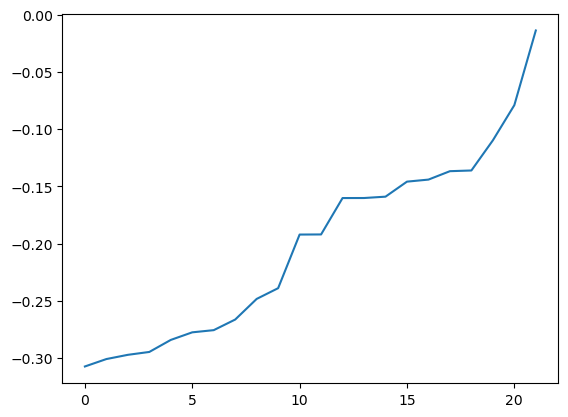

fit df.shape (307501, 40)
Epoch 1/1000
53/53 - 3s - loss: 1.0677 - mse: 1.0065 - weighted_mse: 0.9823 - cosine_similarity: 0.1216 - val_loss: 0.7950 - val_mse: 1.0023 - val_weighted_mse: 0.9942 - val_cosine_similarity: 0.0753 - 3s/epoch - 54ms/step
Epoch 2/1000
53/53 - 1s - loss: 1.0550 - mse: 1.0050 - weighted_mse: 0.9707 - cosine_similarity: 0.1514 - val_loss: 0.7928 - val_mse: 1.0025 - val_weighted_mse: 0.9914 - val_cosine_similarity: 0.0934 - 1s/epoch - 21ms/step
Epoch 3/1000
53/53 - 1s - loss: 1.0465 - mse: 1.0043 - weighted_mse: 0.9628 - cosine_similarity: 0.1623 - val_loss: 0.7908 - val_mse: 1.0003 - val_weighted_mse: 0.9889 - val_cosine_similarity: 0.0979 - 1s/epoch - 26ms/step
Epoch 4/1000
53/53 - 1s - loss: 1.0403 - mse: 1.0036 - weighted_mse: 0.9571 - cosine_similarity: 0.1697 - val_loss: 0.7895 - val_mse: 1.0007 - val_weighted_mse: 0.9874 - val_cosine_similarity: 0.0915 - 1s/epoch - 25ms/step
Epoch 5/1000
53/53 - 1s - loss: 1.0356 - mse: 1.0025 - weighted_mse: 0.9527 - cosi

INFO:tensorflow:Assets written to: /tmp/tmpuggh1gku/assets


INFO:tensorflow:Assets written to: /tmp/tmpuggh1gku/assets
2022-11-22 07:27:59.857567: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 07:27:59.857692: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 07:27:59.857928: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpuggh1gku
2022-11-22 07:27:59.860264: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 07:27:59.860329: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpuggh1gku
2022-11-22 07:27:59.868960: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 07:27:59.932818: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpuggh1gku
2022-11-22 07:27:59.949638: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp9vab9x0x/assets


INFO:tensorflow:Assets written to: /tmp/tmp9vab9x0x/assets
2022-11-22 07:28:01.850113: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 07:28:01.850225: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 07:28:01.850461: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp9vab9x0x
2022-11-22 07:28:01.852795: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 07:28:01.852853: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp9vab9x0x
2022-11-22 07:28:01.860522: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 07:28:01.923305: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp9vab9x0x
2022-11-22 07:28:01.940527: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp6i027u7o/assets


INFO:tensorflow:Assets written to: /tmp/tmp6i027u7o/assets
2022-11-22 07:28:03.831605: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 07:28:03.831717: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 07:28:03.831945: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp6i027u7o
2022-11-22 07:28:03.834160: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 07:28:03.834210: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp6i027u7o
2022-11-22 07:28:03.841772: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 07:28:03.904333: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp6i027u7o
2022-11-22 07:28:03.921097: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp1ru_3scl/assets


INFO:tensorflow:Assets written to: /tmp/tmp1ru_3scl/assets
2022-11-22 07:28:05.807753: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 07:28:05.807843: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 07:28:05.808076: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp1ru_3scl
2022-11-22 07:28:05.810437: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 07:28:05.810493: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp1ru_3scl
2022-11-22 07:28:05.817903: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 07:28:05.881197: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp1ru_3scl
2022-11-22 07:28:05.898639: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpksv3q2ne/assets


INFO:tensorflow:Assets written to: /tmp/tmpksv3q2ne/assets
2022-11-22 07:28:07.800979: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 07:28:07.801089: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 07:28:07.801311: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpksv3q2ne
2022-11-22 07:28:07.803513: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 07:28:07.803563: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpksv3q2ne
2022-11-22 07:28:07.810536: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 07:28:07.873728: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpksv3q2ne
2022-11-22 07:28:07.890703: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpsgk_5y9y/assets


INFO:tensorflow:Assets written to: /tmp/tmpsgk_5y9y/assets
2022-11-22 07:28:09.761840: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 07:28:09.761948: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 07:28:09.762175: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpsgk_5y9y
2022-11-22 07:28:09.764536: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 07:28:09.764589: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpsgk_5y9y
2022-11-22 07:28:09.772457: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 07:28:09.838948: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpsgk_5y9y
2022-11-22 07:28:09.857036: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpdv6qf8yp/assets


INFO:tensorflow:Assets written to: /tmp/tmpdv6qf8yp/assets
2022-11-22 07:28:11.753727: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 07:28:11.753835: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 07:28:11.754062: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpdv6qf8yp
2022-11-22 07:28:11.756318: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 07:28:11.756372: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpdv6qf8yp
2022-11-22 07:28:11.763554: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 07:28:11.826185: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpdv6qf8yp
2022-11-22 07:28:11.843214: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpljl_imlz/assets


INFO:tensorflow:Assets written to: /tmp/tmpljl_imlz/assets
2022-11-22 07:28:13.704466: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 07:28:13.704565: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 07:28:13.704798: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpljl_imlz
2022-11-22 07:28:13.706997: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 07:28:13.707045: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpljl_imlz
2022-11-22 07:28:13.714120: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 07:28:13.774586: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpljl_imlz
2022-11-22 07:28:13.790359: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmporll_xhc/assets


INFO:tensorflow:Assets written to: /tmp/tmporll_xhc/assets
2022-11-22 07:28:15.619272: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 07:28:15.619404: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 07:28:15.619643: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmporll_xhc
2022-11-22 07:28:15.621897: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 07:28:15.621945: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmporll_xhc
2022-11-22 07:28:15.629417: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 07:28:15.692531: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmporll_xhc
2022-11-22 07:28:15.712063: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmppx5s0a_4/assets


INFO:tensorflow:Assets written to: /tmp/tmppx5s0a_4/assets
2022-11-22 07:28:17.633499: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 07:28:17.633611: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 07:28:17.633835: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmppx5s0a_4
2022-11-22 07:28:17.636137: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 07:28:17.636195: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmppx5s0a_4
2022-11-22 07:28:17.643779: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 07:28:17.707874: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmppx5s0a_4
2022-11-22 07:28:17.724651: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

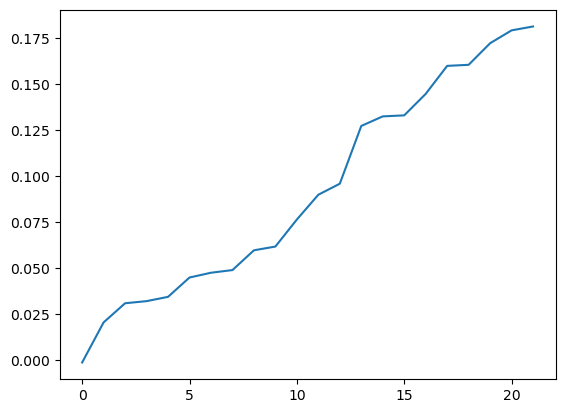

fit df.shape (283904, 40)
Epoch 1/1000
49/49 - 3s - loss: 1.1048 - mse: 1.0093 - weighted_mse: 0.9747 - cosine_similarity: 0.1404 - val_loss: 0.6856 - val_mse: 1.0023 - val_weighted_mse: 0.9920 - val_cosine_similarity: 0.1093 - 3s/epoch - 59ms/step
Epoch 2/1000
49/49 - 1s - loss: 1.0892 - mse: 1.0092 - weighted_mse: 0.9609 - cosine_similarity: 0.1719 - val_loss: 0.6842 - val_mse: 1.0030 - val_weighted_mse: 0.9901 - val_cosine_similarity: 0.0972 - 811ms/epoch - 17ms/step
Epoch 3/1000
49/49 - 1s - loss: 1.0794 - mse: 1.0084 - weighted_mse: 0.9522 - cosine_similarity: 0.1835 - val_loss: 0.6826 - val_mse: 1.0030 - val_weighted_mse: 0.9878 - val_cosine_similarity: 0.0965 - 801ms/epoch - 16ms/step
Epoch 4/1000
49/49 - 1s - loss: 1.0731 - mse: 1.0084 - weighted_mse: 0.9467 - cosine_similarity: 0.1879 - val_loss: 0.6823 - val_mse: 1.0023 - val_weighted_mse: 0.9872 - val_cosine_similarity: 0.0929 - 794ms/epoch - 16ms/step
Epoch 5/1000
49/49 - 1s - loss: 1.0685 - mse: 1.0072 - weighted_mse: 0.94

INFO:tensorflow:Assets written to: /tmp/tmp6leifr07/assets


INFO:tensorflow:Assets written to: /tmp/tmp6leifr07/assets
2022-11-22 07:36:06.336858: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 07:36:06.336976: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 07:36:06.337220: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp6leifr07
2022-11-22 07:36:06.339503: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 07:36:06.339558: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp6leifr07
2022-11-22 07:36:06.346923: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 07:36:06.408603: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp6leifr07
2022-11-22 07:36:06.425791: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpvz29to3u/assets


INFO:tensorflow:Assets written to: /tmp/tmpvz29to3u/assets
2022-11-22 07:36:08.296016: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 07:36:08.296129: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 07:36:08.296355: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpvz29to3u
2022-11-22 07:36:08.298607: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 07:36:08.298665: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpvz29to3u
2022-11-22 07:36:08.306388: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 07:36:08.368982: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpvz29to3u
2022-11-22 07:36:08.386659: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpm2kkh4bi/assets


INFO:tensorflow:Assets written to: /tmp/tmpm2kkh4bi/assets
2022-11-22 07:36:10.310747: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 07:36:10.310856: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 07:36:10.311083: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpm2kkh4bi
2022-11-22 07:36:10.313515: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 07:36:10.313596: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpm2kkh4bi
2022-11-22 07:36:10.322278: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 07:36:10.388747: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpm2kkh4bi
2022-11-22 07:36:10.407814: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpmgzt0mfw/assets


INFO:tensorflow:Assets written to: /tmp/tmpmgzt0mfw/assets
2022-11-22 07:36:12.292774: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 07:36:12.292891: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 07:36:12.293123: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpmgzt0mfw
2022-11-22 07:36:12.295418: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 07:36:12.295477: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpmgzt0mfw
2022-11-22 07:36:12.302907: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 07:36:12.363601: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpmgzt0mfw
2022-11-22 07:36:12.380412: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpavb_ewfd/assets


INFO:tensorflow:Assets written to: /tmp/tmpavb_ewfd/assets
2022-11-22 07:36:14.222185: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 07:36:14.222286: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 07:36:14.222510: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpavb_ewfd
2022-11-22 07:36:14.224758: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 07:36:14.224807: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpavb_ewfd
2022-11-22 07:36:14.232150: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 07:36:14.291838: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpavb_ewfd
2022-11-22 07:36:14.308990: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpcsze4coe/assets


INFO:tensorflow:Assets written to: /tmp/tmpcsze4coe/assets
2022-11-22 07:36:16.180660: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 07:36:16.180766: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 07:36:16.180994: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpcsze4coe
2022-11-22 07:36:16.183167: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 07:36:16.183216: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpcsze4coe
2022-11-22 07:36:16.190447: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 07:36:16.251321: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpcsze4coe
2022-11-22 07:36:16.268025: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpu2zi4_81/assets


INFO:tensorflow:Assets written to: /tmp/tmpu2zi4_81/assets
2022-11-22 07:36:18.153114: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 07:36:18.153223: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 07:36:18.153455: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpu2zi4_81
2022-11-22 07:36:18.155685: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 07:36:18.155755: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpu2zi4_81
2022-11-22 07:36:18.163768: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 07:36:18.229440: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpu2zi4_81
2022-11-22 07:36:18.248404: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp4dxoazd7/assets


INFO:tensorflow:Assets written to: /tmp/tmp4dxoazd7/assets
2022-11-22 07:36:20.150813: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 07:36:20.150925: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 07:36:20.151154: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp4dxoazd7
2022-11-22 07:36:20.153451: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 07:36:20.153517: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp4dxoazd7
2022-11-22 07:36:20.160860: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 07:36:20.222170: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp4dxoazd7
2022-11-22 07:36:20.238324: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp9jxl1bgh/assets


INFO:tensorflow:Assets written to: /tmp/tmp9jxl1bgh/assets
2022-11-22 07:36:22.113110: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 07:36:22.113225: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 07:36:22.113449: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp9jxl1bgh
2022-11-22 07:36:22.115710: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 07:36:22.115771: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp9jxl1bgh
2022-11-22 07:36:22.123062: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 07:36:22.184331: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp9jxl1bgh
2022-11-22 07:36:22.201319: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp4foy6ly0/assets


INFO:tensorflow:Assets written to: /tmp/tmp4foy6ly0/assets
2022-11-22 07:36:24.102756: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 07:36:24.102865: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 07:36:24.103095: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp4foy6ly0
2022-11-22 07:36:24.105394: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 07:36:24.105450: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp4foy6ly0
2022-11-22 07:36:24.113315: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 07:36:24.176603: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp4foy6ly0
2022-11-22 07:36:24.193795: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

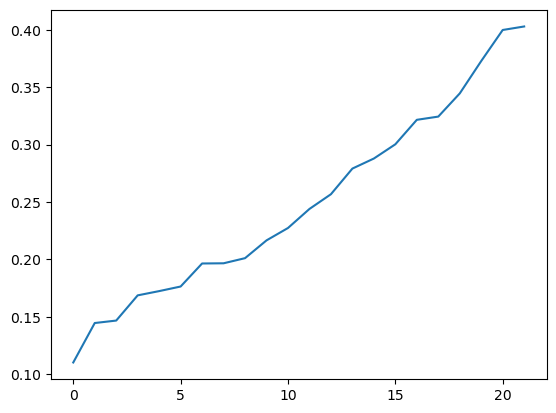

fit df.shape (244756, 40)
Epoch 1/1000
42/42 - 3s - loss: 1.0995 - mse: 1.0047 - weighted_mse: 0.9784 - cosine_similarity: 0.1399 - val_loss: 0.7080 - val_mse: 1.0006 - val_weighted_mse: 0.9914 - val_cosine_similarity: 0.1102 - 3s/epoch - 68ms/step
Epoch 2/1000
42/42 - 1s - loss: 1.0854 - mse: 1.0008 - weighted_mse: 0.9658 - cosine_similarity: 0.1525 - val_loss: 0.7062 - val_mse: 0.9991 - val_weighted_mse: 0.9890 - val_cosine_similarity: 0.0877 - 749ms/epoch - 18ms/step
Epoch 3/1000
42/42 - 1s - loss: 1.0767 - mse: 0.9985 - weighted_mse: 0.9581 - cosine_similarity: 0.1617 - val_loss: 0.7044 - val_mse: 0.9993 - val_weighted_mse: 0.9864 - val_cosine_similarity: 0.0834 - 747ms/epoch - 18ms/step
Epoch 4/1000
42/42 - 1s - loss: 1.0707 - mse: 0.9983 - weighted_mse: 0.9527 - cosine_similarity: 0.1669 - val_loss: 0.7041 - val_mse: 0.9997 - val_weighted_mse: 0.9860 - val_cosine_similarity: 0.0891 - 741ms/epoch - 18ms/step
Epoch 5/1000
42/42 - 1s - loss: 1.0659 - mse: 0.9982 - weighted_mse: 0.94

INFO:tensorflow:Assets written to: /tmp/tmpdeuq733g/assets


INFO:tensorflow:Assets written to: /tmp/tmpdeuq733g/assets
2022-11-22 07:43:15.946419: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 07:43:15.946519: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 07:43:15.946765: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpdeuq733g
2022-11-22 07:43:15.949079: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 07:43:15.949142: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpdeuq733g
2022-11-22 07:43:15.956816: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 07:43:16.017880: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpdeuq733g
2022-11-22 07:43:16.034597: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpw_a05kml/assets


INFO:tensorflow:Assets written to: /tmp/tmpw_a05kml/assets
2022-11-22 07:43:17.947913: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 07:43:17.948014: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 07:43:17.948243: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpw_a05kml
2022-11-22 07:43:17.950484: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 07:43:17.950545: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpw_a05kml
2022-11-22 07:43:17.957964: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 07:43:18.020774: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpw_a05kml
2022-11-22 07:43:18.037632: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmps6z4m52z/assets


INFO:tensorflow:Assets written to: /tmp/tmps6z4m52z/assets
2022-11-22 07:43:19.901947: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 07:43:19.902056: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 07:43:19.902293: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmps6z4m52z
2022-11-22 07:43:19.904536: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 07:43:19.904589: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmps6z4m52z
2022-11-22 07:43:19.911906: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 07:43:19.973412: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmps6z4m52z
2022-11-22 07:43:19.990543: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpbh_m9eip/assets


INFO:tensorflow:Assets written to: /tmp/tmpbh_m9eip/assets
2022-11-22 07:43:21.877119: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 07:43:21.877227: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 07:43:21.877462: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpbh_m9eip
2022-11-22 07:43:21.879737: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 07:43:21.879790: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpbh_m9eip
2022-11-22 07:43:21.887256: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 07:43:21.949997: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpbh_m9eip
2022-11-22 07:43:21.967527: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpjhvvn9fm/assets


INFO:tensorflow:Assets written to: /tmp/tmpjhvvn9fm/assets
2022-11-22 07:43:23.847494: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 07:43:23.847595: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 07:43:23.847827: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpjhvvn9fm
2022-11-22 07:43:23.850027: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 07:43:23.850074: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpjhvvn9fm
2022-11-22 07:43:23.857474: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 07:43:23.920907: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpjhvvn9fm
2022-11-22 07:43:23.938217: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmph_jjygsa/assets


INFO:tensorflow:Assets written to: /tmp/tmph_jjygsa/assets
2022-11-22 07:43:25.880408: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 07:43:25.880520: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 07:43:25.880761: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmph_jjygsa
2022-11-22 07:43:25.883022: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 07:43:25.883078: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmph_jjygsa
2022-11-22 07:43:25.890601: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 07:43:25.953602: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmph_jjygsa
2022-11-22 07:43:25.971176: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp_s1786_g/assets


INFO:tensorflow:Assets written to: /tmp/tmp_s1786_g/assets
2022-11-22 07:43:27.897446: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 07:43:27.897564: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 07:43:27.897807: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp_s1786_g
2022-11-22 07:43:27.900107: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 07:43:27.900168: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp_s1786_g
2022-11-22 07:43:27.907501: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 07:43:27.968818: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp_s1786_g
2022-11-22 07:43:27.985519: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmptj3ntz4o/assets


INFO:tensorflow:Assets written to: /tmp/tmptj3ntz4o/assets
2022-11-22 07:43:29.873190: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 07:43:29.873293: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 07:43:29.873519: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmptj3ntz4o
2022-11-22 07:43:29.875782: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 07:43:29.875836: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmptj3ntz4o
2022-11-22 07:43:29.883068: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 07:43:29.944202: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmptj3ntz4o
2022-11-22 07:43:29.962058: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpurpsp25l/assets


INFO:tensorflow:Assets written to: /tmp/tmpurpsp25l/assets
2022-11-22 07:43:31.866289: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 07:43:31.866380: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 07:43:31.866610: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpurpsp25l
2022-11-22 07:43:31.870535: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 07:43:31.870610: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpurpsp25l
2022-11-22 07:43:31.878486: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 07:43:31.943540: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpurpsp25l
2022-11-22 07:43:31.961348: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpwcunjqa1/assets


INFO:tensorflow:Assets written to: /tmp/tmpwcunjqa1/assets
2022-11-22 07:43:36.147864: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 07:43:36.147966: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 07:43:36.148197: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpwcunjqa1
2022-11-22 07:43:36.152950: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 07:43:36.153067: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpwcunjqa1
2022-11-22 07:43:36.167916: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 07:43:36.243692: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpwcunjqa1
2022-11-22 07:43:36.267805: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

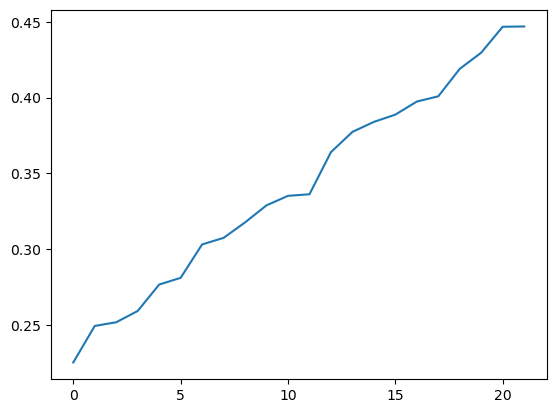

fit df.shape (226471, 40)
Epoch 1/1000
39/39 - 5s - loss: 0.9694 - mse: 1.0035 - weighted_mse: 0.9815 - cosine_similarity: 0.1279 - val_loss: 1.0169 - val_mse: 0.9993 - val_weighted_mse: 0.9885 - val_cosine_similarity: 0.1428 - 5s/epoch - 139ms/step
Epoch 2/1000
39/39 - 1s - loss: 0.9560 - mse: 0.9997 - weighted_mse: 0.9679 - cosine_similarity: 0.1583 - val_loss: 1.0122 - val_mse: 0.9971 - val_weighted_mse: 0.9839 - val_cosine_similarity: 0.1430 - 1s/epoch - 27ms/step
Epoch 3/1000
39/39 - 1s - loss: 0.9480 - mse: 0.9989 - weighted_mse: 0.9598 - cosine_similarity: 0.1645 - val_loss: 1.0103 - val_mse: 0.9943 - val_weighted_mse: 0.9821 - val_cosine_similarity: 0.1337 - 1s/epoch - 28ms/step
Epoch 4/1000
39/39 - 1s - loss: 0.9419 - mse: 0.9983 - weighted_mse: 0.9536 - cosine_similarity: 0.1713 - val_loss: 1.0066 - val_mse: 0.9922 - val_weighted_mse: 0.9785 - val_cosine_similarity: 0.1318 - 1s/epoch - 27ms/step
Epoch 5/1000
39/39 - 1s - loss: 0.9367 - mse: 0.9968 - weighted_mse: 0.9484 - cos

INFO:tensorflow:Assets written to: /tmp/tmpqv2jixx3/assets


INFO:tensorflow:Assets written to: /tmp/tmpqv2jixx3/assets
2022-11-22 07:52:02.476063: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 07:52:02.476171: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 07:52:02.476433: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpqv2jixx3
2022-11-22 07:52:02.478739: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 07:52:02.478806: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpqv2jixx3
2022-11-22 07:52:02.486678: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 07:52:02.550296: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpqv2jixx3
2022-11-22 07:52:02.567606: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpnjessby1/assets


INFO:tensorflow:Assets written to: /tmp/tmpnjessby1/assets
2022-11-22 07:52:04.458085: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 07:52:04.458179: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 07:52:04.458415: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpnjessby1
2022-11-22 07:52:04.460746: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 07:52:04.460806: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpnjessby1
2022-11-22 07:52:04.468408: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 07:52:04.534055: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpnjessby1
2022-11-22 07:52:04.550348: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp4rx8a7dq/assets


INFO:tensorflow:Assets written to: /tmp/tmp4rx8a7dq/assets
2022-11-22 07:52:06.413396: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 07:52:06.413501: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 07:52:06.413736: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp4rx8a7dq
2022-11-22 07:52:06.415977: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 07:52:06.416035: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp4rx8a7dq
2022-11-22 07:52:06.423525: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 07:52:06.487413: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp4rx8a7dq
2022-11-22 07:52:06.505122: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpnn8quzzj/assets


INFO:tensorflow:Assets written to: /tmp/tmpnn8quzzj/assets
2022-11-22 07:52:08.399612: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 07:52:08.399722: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 07:52:08.399949: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpnn8quzzj
2022-11-22 07:52:08.402170: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 07:52:08.402217: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpnn8quzzj
2022-11-22 07:52:08.409608: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 07:52:08.471215: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpnn8quzzj
2022-11-22 07:52:08.488954: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmplfird353/assets


INFO:tensorflow:Assets written to: /tmp/tmplfird353/assets
2022-11-22 07:52:10.387647: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 07:52:10.387760: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 07:52:10.387988: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmplfird353
2022-11-22 07:52:10.390179: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 07:52:10.390228: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmplfird353
2022-11-22 07:52:10.398746: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 07:52:10.461304: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmplfird353
2022-11-22 07:52:10.478409: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpk_piri8q/assets


INFO:tensorflow:Assets written to: /tmp/tmpk_piri8q/assets
2022-11-22 07:52:12.326611: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 07:52:12.326722: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 07:52:12.326944: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpk_piri8q
2022-11-22 07:52:12.329134: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 07:52:12.329181: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpk_piri8q
2022-11-22 07:52:12.336422: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 07:52:12.397364: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpk_piri8q
2022-11-22 07:52:12.413868: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp7qfocb18/assets


INFO:tensorflow:Assets written to: /tmp/tmp7qfocb18/assets
2022-11-22 07:52:14.279814: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 07:52:14.279921: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 07:52:14.280147: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp7qfocb18
2022-11-22 07:52:14.282338: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 07:52:14.282389: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp7qfocb18
2022-11-22 07:52:14.290141: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 07:52:14.352379: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp7qfocb18
2022-11-22 07:52:14.369364: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpffa1nr6j/assets


INFO:tensorflow:Assets written to: /tmp/tmpffa1nr6j/assets
2022-11-22 07:52:16.297654: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 07:52:16.297763: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 07:52:16.297990: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpffa1nr6j
2022-11-22 07:52:16.300224: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 07:52:16.300272: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpffa1nr6j
2022-11-22 07:52:16.307540: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 07:52:16.368067: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpffa1nr6j
2022-11-22 07:52:16.384730: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpm8wyrb21/assets


INFO:tensorflow:Assets written to: /tmp/tmpm8wyrb21/assets
2022-11-22 07:52:18.264281: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 07:52:18.264386: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 07:52:18.264610: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpm8wyrb21
2022-11-22 07:52:18.266809: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 07:52:18.266861: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpm8wyrb21
2022-11-22 07:52:18.274372: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 07:52:18.337044: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpm8wyrb21
2022-11-22 07:52:18.354113: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpro1a6yjj/assets


INFO:tensorflow:Assets written to: /tmp/tmpro1a6yjj/assets
2022-11-22 07:52:20.229106: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 07:52:20.229218: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 07:52:20.229447: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpro1a6yjj
2022-11-22 07:52:20.231681: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 07:52:20.231739: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpro1a6yjj
2022-11-22 07:52:20.238958: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 07:52:20.298482: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpro1a6yjj
2022-11-22 07:52:20.314295: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

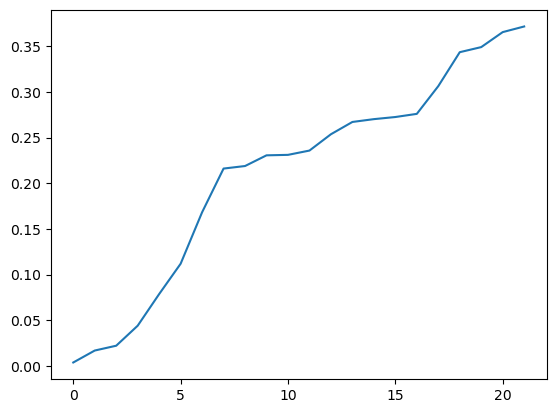

return without cost statistics
mean 0.0035823774552076297
std 0.03550891152340116
sharpe 0.10088671551778668
double sharpe 0.9430114135775167
max drawdown 21.044483041919435
min -1.0456428254171577
min sharpe 0.003426004911168826
return with cost statistics
mean 0.002613984425887746
std 0.035519245585182914
sharpe 0.0735934669450915
double sharpe 0.5646840488844254
max drawdown 22.32348310266868
min -1.0476428255121526
min sharpe 0.002495110320265753


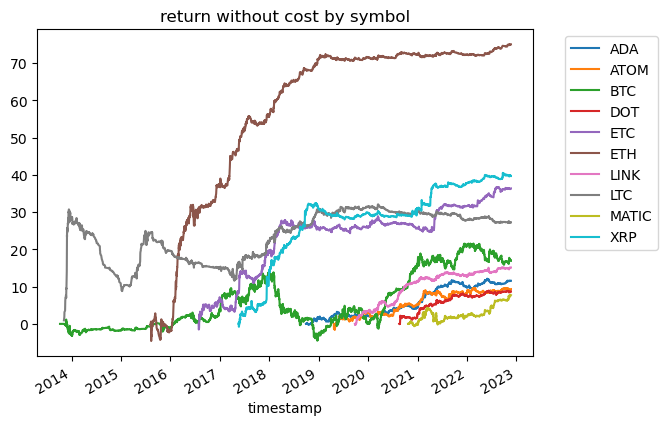

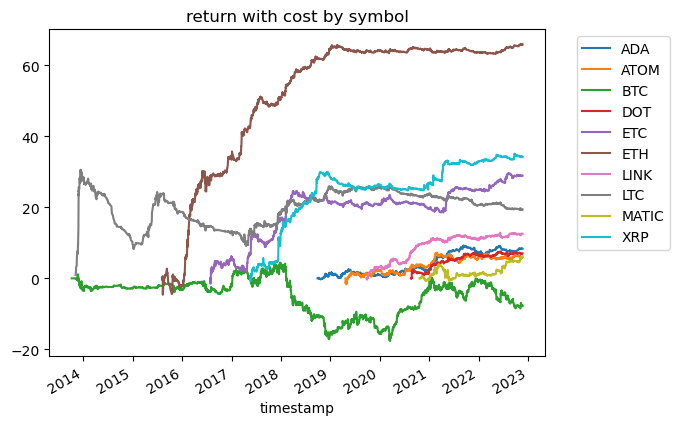

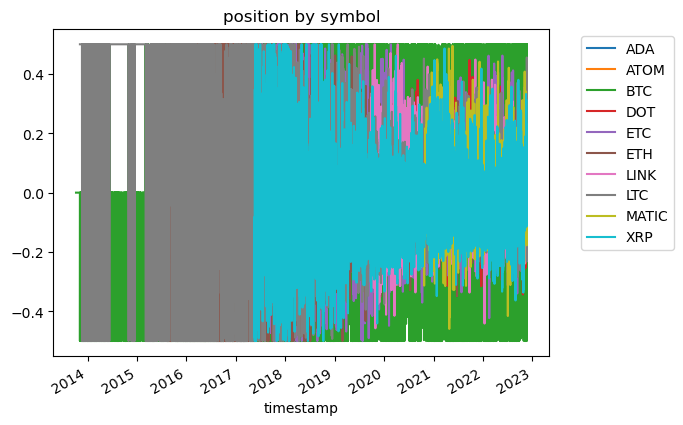

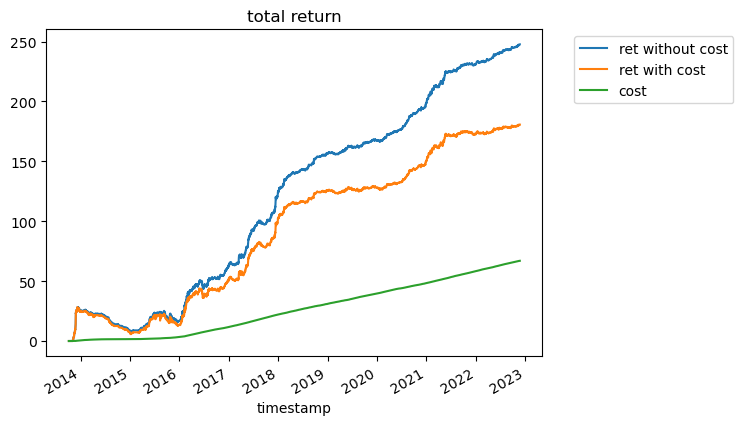

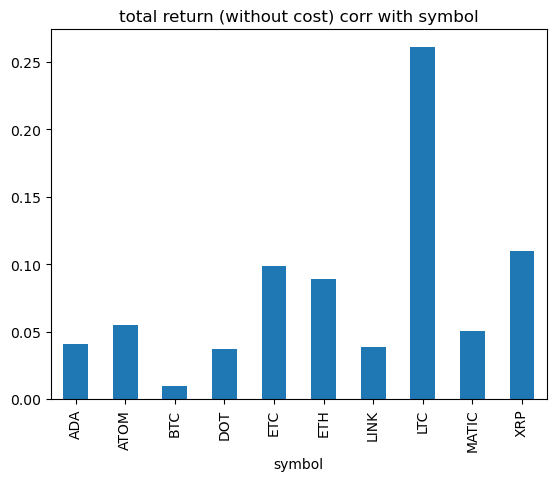

return without cost statistics
mean 0.002765632946959712
std 0.017319602418232053
sharpe 0.15968224213093812
double sharpe 1.0048187797990893
max drawdown 4.621708476021147
min -0.16960200647246704
min sharpe 0.01630660511913626
return with cost statistics
mean 0.0017699169022464352
std 0.01731315823164077
sharpe 0.10222958044776674
double sharpe 0.5548830755294595
max drawdown 5.561096118419283
min -0.17125223823369917
min sharpe 0.010335146100870928


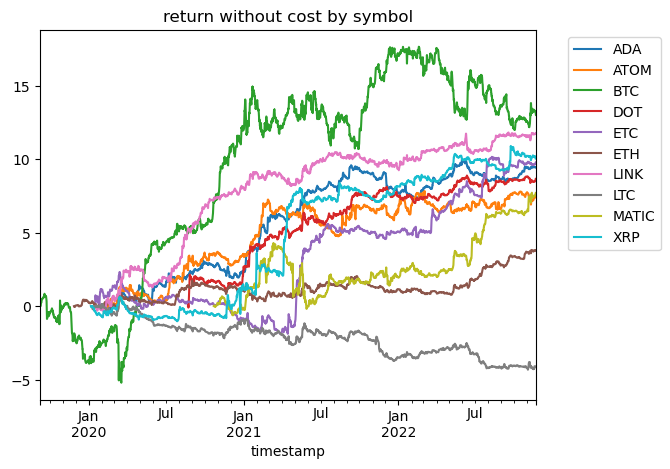

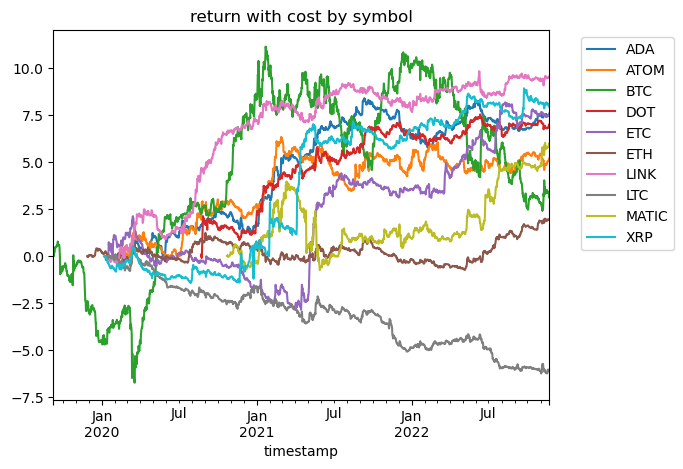

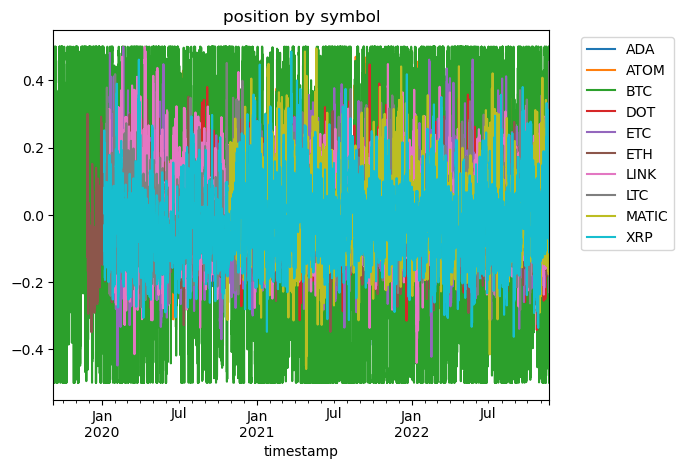

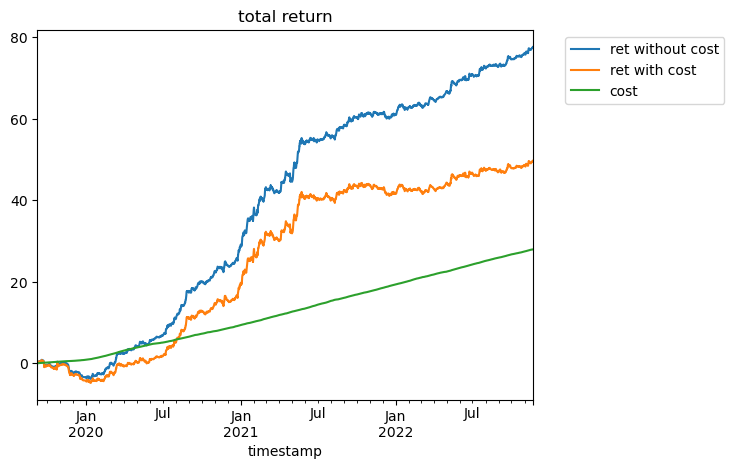

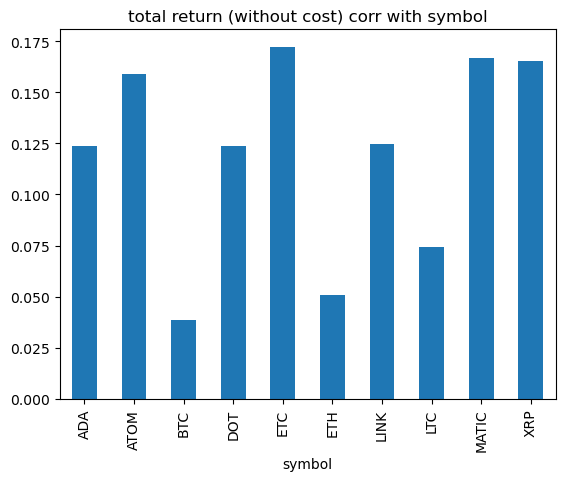

fit df.shape (351166, 40)


INFO:tensorflow:Assets written to: /tmp/tmpbcw1eu9h/assets


INFO:tensorflow:Assets written to: /tmp/tmpbcw1eu9h/assets
2022-11-22 09:34:33.931026: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 09:34:33.931142: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 09:34:33.931387: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpbcw1eu9h
2022-11-22 09:34:33.933651: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 09:34:33.933701: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpbcw1eu9h
2022-11-22 09:34:33.940967: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 09:34:34.002809: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpbcw1eu9h
2022-11-22 09:34:34.019310: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpztjv4sy8/assets


INFO:tensorflow:Assets written to: /tmp/tmpztjv4sy8/assets
2022-11-22 09:34:35.878724: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 09:34:35.878829: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 09:34:35.879055: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpztjv4sy8
2022-11-22 09:34:35.881346: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 09:34:35.881403: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpztjv4sy8
2022-11-22 09:34:35.889068: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 09:34:35.950093: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpztjv4sy8
2022-11-22 09:34:35.966862: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpmj4pbygq/assets


INFO:tensorflow:Assets written to: /tmp/tmpmj4pbygq/assets
2022-11-22 09:34:37.842771: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 09:34:37.842881: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 09:34:37.843109: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpmj4pbygq
2022-11-22 09:34:37.845638: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 09:34:37.845697: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpmj4pbygq
2022-11-22 09:34:37.857059: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 09:34:37.921293: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpmj4pbygq
2022-11-22 09:34:37.938734: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpai5kx4to/assets


INFO:tensorflow:Assets written to: /tmp/tmpai5kx4to/assets
2022-11-22 09:34:39.836987: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 09:34:39.837086: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 09:34:39.837312: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpai5kx4to
2022-11-22 09:34:39.839802: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 09:34:39.839857: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpai5kx4to
2022-11-22 09:34:39.851122: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 09:34:39.916312: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpai5kx4to
2022-11-22 09:34:39.933027: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpvbvwwvtu/assets


INFO:tensorflow:Assets written to: /tmp/tmpvbvwwvtu/assets
2022-11-22 09:34:41.868451: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 09:34:41.868554: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 09:34:41.868783: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpvbvwwvtu
2022-11-22 09:34:41.871309: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 09:34:41.871405: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpvbvwwvtu
2022-11-22 09:34:41.883043: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 09:34:41.947529: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpvbvwwvtu
2022-11-22 09:34:41.964775: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpkconp7ce/assets


INFO:tensorflow:Assets written to: /tmp/tmpkconp7ce/assets
2022-11-22 09:34:46.296797: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 09:34:46.296907: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 09:34:46.297146: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpkconp7ce
2022-11-22 09:34:46.302494: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 09:34:46.302575: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpkconp7ce
2022-11-22 09:34:46.320322: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 09:34:46.408531: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpkconp7ce
2022-11-22 09:34:46.436896: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpt4qsf711/assets


INFO:tensorflow:Assets written to: /tmp/tmpt4qsf711/assets
2022-11-22 09:34:48.463639: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 09:34:48.463745: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 09:34:48.463968: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpt4qsf711
2022-11-22 09:34:48.466722: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 09:34:48.466772: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpt4qsf711
2022-11-22 09:34:48.475389: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 09:34:48.539136: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpt4qsf711
2022-11-22 09:34:48.557324: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpux625cmb/assets


INFO:tensorflow:Assets written to: /tmp/tmpux625cmb/assets
2022-11-22 09:34:50.427966: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 09:34:50.428067: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 09:34:50.428288: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpux625cmb
2022-11-22 09:34:50.430608: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 09:34:50.430657: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpux625cmb
2022-11-22 09:34:50.438401: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 09:34:50.502416: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpux625cmb
2022-11-22 09:34:50.519992: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpwjwwdije/assets


INFO:tensorflow:Assets written to: /tmp/tmpwjwwdije/assets
2022-11-22 09:34:52.346280: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 09:34:52.346381: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 09:34:52.346607: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpwjwwdije
2022-11-22 09:34:52.348894: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 09:34:52.348942: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpwjwwdije
2022-11-22 09:34:52.356356: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 09:34:52.419906: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpwjwwdije
2022-11-22 09:34:52.437050: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpq9ntdicp/assets


INFO:tensorflow:Assets written to: /tmp/tmpq9ntdicp/assets
2022-11-22 09:34:54.289476: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 09:34:54.289581: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 09:34:54.289817: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpq9ntdicp
2022-11-22 09:34:54.292094: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 09:34:54.292145: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpq9ntdicp
2022-11-22 09:34:54.299615: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 09:34:54.362426: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpq9ntdicp
2022-11-22 09:34:54.379815: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmprreuca35/assets


INFO:tensorflow:Assets written to: /tmp/tmprreuca35/assets
2022-11-22 09:34:56.246974: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 09:34:56.247075: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 09:34:56.247310: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmprreuca35
2022-11-22 09:34:56.249534: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 09:34:56.249580: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmprreuca35
2022-11-22 09:34:56.256913: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 09:34:56.319284: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmprreuca35
2022-11-22 09:34:56.335529: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp_q3p0euq/assets


INFO:tensorflow:Assets written to: /tmp/tmp_q3p0euq/assets
2022-11-22 09:34:58.187799: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 09:34:58.187893: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 09:34:58.188120: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp_q3p0euq
2022-11-22 09:34:58.190332: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 09:34:58.190384: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp_q3p0euq
2022-11-22 09:34:58.197898: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 09:34:58.259806: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp_q3p0euq
2022-11-22 09:34:58.277305: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpml7uqs5n/assets


INFO:tensorflow:Assets written to: /tmp/tmpml7uqs5n/assets
2022-11-22 09:35:00.121495: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 09:35:00.121609: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 09:35:00.121834: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpml7uqs5n
2022-11-22 09:35:00.124096: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 09:35:00.124146: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpml7uqs5n
2022-11-22 09:35:00.131511: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 09:35:00.194261: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpml7uqs5n
2022-11-22 09:35:00.210285: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpbuqgnfa2/assets


INFO:tensorflow:Assets written to: /tmp/tmpbuqgnfa2/assets
2022-11-22 09:35:02.079716: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 09:35:02.079825: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 09:35:02.080050: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpbuqgnfa2
2022-11-22 09:35:02.082673: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 09:35:02.082734: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpbuqgnfa2
2022-11-22 09:35:02.090931: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 09:35:02.156034: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpbuqgnfa2
2022-11-22 09:35:02.173490: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpl_srkkwu/assets


INFO:tensorflow:Assets written to: /tmp/tmpl_srkkwu/assets
2022-11-22 09:35:04.021281: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 09:35:04.021386: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 09:35:04.021614: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpl_srkkwu
2022-11-22 09:35:04.023840: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 09:35:04.023890: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpl_srkkwu
2022-11-22 09:35:04.031168: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 09:35:04.092446: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpl_srkkwu
2022-11-22 09:35:04.108856: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpt4rw4jal/assets


INFO:tensorflow:Assets written to: /tmp/tmpt4rw4jal/assets
2022-11-22 09:35:05.982868: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 09:35:05.982973: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 09:35:05.983216: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpt4rw4jal
2022-11-22 09:35:05.985524: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 09:35:05.985580: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpt4rw4jal
2022-11-22 09:35:05.993154: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 09:35:06.054870: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpt4rw4jal
2022-11-22 09:35:06.071714: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpmgb0ncz_/assets


INFO:tensorflow:Assets written to: /tmp/tmpmgb0ncz_/assets
2022-11-22 09:35:07.934795: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 09:35:07.934902: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 09:35:07.935126: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpmgb0ncz_
2022-11-22 09:35:07.937448: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 09:35:07.937505: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpmgb0ncz_
2022-11-22 09:35:07.945069: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 09:35:08.007561: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpmgb0ncz_
2022-11-22 09:35:08.024290: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpv6600gug/assets


INFO:tensorflow:Assets written to: /tmp/tmpv6600gug/assets
2022-11-22 09:35:09.899086: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 09:35:09.899198: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 09:35:09.899445: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpv6600gug
2022-11-22 09:35:09.901665: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 09:35:09.901731: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpv6600gug
2022-11-22 09:35:09.909211: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 09:35:09.972783: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpv6600gug
2022-11-22 09:35:09.989690: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpz93gmy3_/assets


INFO:tensorflow:Assets written to: /tmp/tmpz93gmy3_/assets
2022-11-22 09:35:14.903946: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 09:35:14.904050: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 09:35:14.904293: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpz93gmy3_
2022-11-22 09:35:14.910089: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 09:35:14.910167: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpz93gmy3_
2022-11-22 09:35:14.938232: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 09:35:15.082239: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpz93gmy3_
2022-11-22 09:35:15.129887: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpz82772u9/assets


INFO:tensorflow:Assets written to: /tmp/tmpz82772u9/assets
2022-11-22 09:35:17.596855: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 09:35:17.596962: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 09:35:17.597207: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpz82772u9
2022-11-22 09:35:17.603183: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 09:35:17.603261: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpz82772u9
2022-11-22 09:35:17.626028: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 09:35:17.736231: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpz82772u9
2022-11-22 09:35:17.769321: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpt5b_jnij/assets


INFO:tensorflow:Assets written to: /tmp/tmpt5b_jnij/assets
2022-11-22 09:35:19.888407: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 09:35:19.888513: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 09:35:19.888756: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpt5b_jnij
2022-11-22 09:35:19.892701: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 09:35:19.892775: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpt5b_jnij
2022-11-22 09:35:19.903608: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 09:35:19.972822: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpt5b_jnij
2022-11-22 09:35:19.991937: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpjd6wfy46/assets


INFO:tensorflow:Assets written to: /tmp/tmpjd6wfy46/assets
2022-11-22 09:35:21.940019: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 09:35:21.940121: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 09:35:21.940353: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpjd6wfy46
2022-11-22 09:35:21.942798: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 09:35:21.942847: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpjd6wfy46
2022-11-22 09:35:21.950914: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 09:35:22.016684: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpjd6wfy46
2022-11-22 09:35:22.033793: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmparao_99w/assets


INFO:tensorflow:Assets written to: /tmp/tmparao_99w/assets
2022-11-22 09:35:23.921799: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 09:35:23.921903: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 09:35:23.922124: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmparao_99w
2022-11-22 09:35:23.924444: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 09:35:23.924488: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmparao_99w
2022-11-22 09:35:23.932265: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 09:35:23.996099: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmparao_99w
2022-11-22 09:35:24.014260: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpt1ql9z7v/assets


INFO:tensorflow:Assets written to: /tmp/tmpt1ql9z7v/assets
2022-11-22 09:35:25.893613: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 09:35:25.893736: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 09:35:25.893969: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpt1ql9z7v
2022-11-22 09:35:25.896333: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 09:35:25.896401: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpt1ql9z7v
2022-11-22 09:35:25.904323: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 09:35:25.970438: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpt1ql9z7v
2022-11-22 09:35:25.988719: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpxazcpcbe/assets


INFO:tensorflow:Assets written to: /tmp/tmpxazcpcbe/assets
2022-11-22 09:35:27.841711: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 09:35:27.841816: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 09:35:27.842041: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpxazcpcbe
2022-11-22 09:35:27.844336: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 09:35:27.844384: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpxazcpcbe
2022-11-22 09:35:27.851863: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 09:35:27.914197: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpxazcpcbe
2022-11-22 09:35:27.930856: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp2q3l5ode/assets


INFO:tensorflow:Assets written to: /tmp/tmp2q3l5ode/assets
2022-11-22 09:35:29.818379: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 09:35:29.818485: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 09:35:29.818719: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp2q3l5ode
2022-11-22 09:35:29.820990: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 09:35:29.821034: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp2q3l5ode
2022-11-22 09:35:29.828593: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 09:35:29.891876: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp2q3l5ode
2022-11-22 09:35:29.909415: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpfh2oq06x/assets


INFO:tensorflow:Assets written to: /tmp/tmpfh2oq06x/assets
2022-11-22 09:35:31.804044: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 09:35:31.804141: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 09:35:31.804376: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpfh2oq06x
2022-11-22 09:35:31.806695: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 09:35:31.806757: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpfh2oq06x
2022-11-22 09:35:31.814520: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 09:35:31.878251: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpfh2oq06x
2022-11-22 09:35:31.896446: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpccq7s1o_/assets


INFO:tensorflow:Assets written to: /tmp/tmpccq7s1o_/assets
2022-11-22 09:35:33.754024: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 09:35:33.754126: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 09:35:33.754356: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpccq7s1o_
2022-11-22 09:35:33.756624: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 09:35:33.756679: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpccq7s1o_
2022-11-22 09:35:33.763923: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 09:35:33.825592: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpccq7s1o_
2022-11-22 09:35:33.842025: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpr9k1hasi/assets


INFO:tensorflow:Assets written to: /tmp/tmpr9k1hasi/assets
2022-11-22 09:35:35.665707: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 09:35:35.665813: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 09:35:35.666040: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpr9k1hasi
2022-11-22 09:35:35.668403: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 09:35:35.668466: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpr9k1hasi
2022-11-22 09:35:35.676067: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 09:35:35.737815: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpr9k1hasi
2022-11-22 09:35:35.754658: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpucunyrqg/assets


INFO:tensorflow:Assets written to: /tmp/tmpucunyrqg/assets
2022-11-22 09:35:37.606573: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 09:35:37.606691: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 09:35:37.606924: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpucunyrqg
2022-11-22 09:35:37.609164: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 09:35:37.609217: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpucunyrqg
2022-11-22 09:35:37.616677: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 09:35:37.681671: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpucunyrqg
2022-11-22 09:35:37.698827: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp1ru1v11b/assets


INFO:tensorflow:Assets written to: /tmp/tmp1ru1v11b/assets
2022-11-22 09:35:39.542095: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 09:35:39.542199: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 09:35:39.542421: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp1ru1v11b
2022-11-22 09:35:39.544671: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 09:35:39.544718: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp1ru1v11b
2022-11-22 09:35:39.551904: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 09:35:39.613162: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp1ru1v11b
2022-11-22 09:35:39.630371: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpnavvwyym/assets


INFO:tensorflow:Assets written to: /tmp/tmpnavvwyym/assets
2022-11-22 09:35:44.549350: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 09:35:44.549450: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 09:35:44.549696: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpnavvwyym
2022-11-22 09:35:44.555508: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 09:35:44.555593: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpnavvwyym
2022-11-22 09:35:44.578367: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 09:35:44.683063: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpnavvwyym
2022-11-22 09:35:44.715852: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp5r_y85ce/assets


INFO:tensorflow:Assets written to: /tmp/tmp5r_y85ce/assets
2022-11-22 09:35:46.993488: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 09:35:46.993586: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 09:35:46.993829: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp5r_y85ce
2022-11-22 09:35:46.998486: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 09:35:46.998558: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp5r_y85ce
2022-11-22 09:35:47.014082: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 09:35:47.090915: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp5r_y85ce
2022-11-22 09:35:47.116474: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpdtr68kpo/assets


INFO:tensorflow:Assets written to: /tmp/tmpdtr68kpo/assets
2022-11-22 09:35:49.089205: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 09:35:49.089311: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 09:35:49.089547: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpdtr68kpo
2022-11-22 09:35:49.092359: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 09:35:49.092418: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpdtr68kpo
2022-11-22 09:35:49.101397: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 09:35:49.169040: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpdtr68kpo
2022-11-22 09:35:49.190378: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpns6d9a30/assets


INFO:tensorflow:Assets written to: /tmp/tmpns6d9a30/assets
2022-11-22 09:35:51.072291: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 09:35:51.072398: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 09:35:51.072647: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpns6d9a30
2022-11-22 09:35:51.075197: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 09:35:51.075250: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpns6d9a30
2022-11-22 09:35:51.083458: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 09:35:51.148827: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpns6d9a30
2022-11-22 09:35:51.167285: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpqokl6137/assets


INFO:tensorflow:Assets written to: /tmp/tmpqokl6137/assets
2022-11-22 09:35:53.065823: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 09:35:53.065932: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 09:35:53.066166: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpqokl6137
2022-11-22 09:35:53.068548: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 09:35:53.068602: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpqokl6137
2022-11-22 09:35:53.076609: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 09:35:53.140553: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpqokl6137
2022-11-22 09:35:53.158405: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmplmiakqjw/assets


INFO:tensorflow:Assets written to: /tmp/tmplmiakqjw/assets
2022-11-22 09:35:55.060568: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 09:35:55.060679: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 09:35:55.060924: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmplmiakqjw
2022-11-22 09:35:55.063205: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 09:35:55.063262: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmplmiakqjw
2022-11-22 09:35:55.071028: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 09:35:55.136202: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmplmiakqjw
2022-11-22 09:35:55.155176: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpdeb7uguv/assets


INFO:tensorflow:Assets written to: /tmp/tmpdeb7uguv/assets
2022-11-22 09:35:57.064471: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 09:35:57.064580: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 09:35:57.064819: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpdeb7uguv
2022-11-22 09:35:57.067108: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 09:35:57.067162: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpdeb7uguv
2022-11-22 09:35:57.074903: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 09:35:57.140691: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpdeb7uguv
2022-11-22 09:35:57.158142: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpasz1vj8v/assets


INFO:tensorflow:Assets written to: /tmp/tmpasz1vj8v/assets
2022-11-22 09:35:59.042623: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 09:35:59.042734: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 09:35:59.042970: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpasz1vj8v
2022-11-22 09:35:59.045219: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 09:35:59.045267: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpasz1vj8v
2022-11-22 09:35:59.052778: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 09:35:59.116982: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpasz1vj8v
2022-11-22 09:35:59.134369: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp04uzllh5/assets


INFO:tensorflow:Assets written to: /tmp/tmp04uzllh5/assets
2022-11-22 09:36:01.016180: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 09:36:01.016293: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 09:36:01.016524: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp04uzllh5
2022-11-22 09:36:01.018784: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 09:36:01.018835: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp04uzllh5
2022-11-22 09:36:01.026674: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 09:36:01.090647: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp04uzllh5
2022-11-22 09:36:01.108218: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp73mvr5v6/assets


INFO:tensorflow:Assets written to: /tmp/tmp73mvr5v6/assets
2022-11-22 09:36:03.016927: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 09:36:03.017027: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 09:36:03.017247: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp73mvr5v6
2022-11-22 09:36:03.019463: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 09:36:03.019511: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp73mvr5v6
2022-11-22 09:36:03.026801: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 09:36:03.088110: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp73mvr5v6
2022-11-22 09:36:03.104751: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmplpvm9eol/assets


INFO:tensorflow:Assets written to: /tmp/tmplpvm9eol/assets
2022-11-22 09:36:04.928018: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 09:36:04.928124: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 09:36:04.928350: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmplpvm9eol
2022-11-22 09:36:04.930578: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 09:36:04.930627: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmplpvm9eol
2022-11-22 09:36:04.938335: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 09:36:05.000760: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmplpvm9eol
2022-11-22 09:36:05.017765: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpgi7dd6a3/assets


INFO:tensorflow:Assets written to: /tmp/tmpgi7dd6a3/assets
2022-11-22 09:36:09.558729: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 09:36:09.558836: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 09:36:09.559080: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpgi7dd6a3
2022-11-22 09:36:09.564835: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 09:36:09.564969: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpgi7dd6a3
2022-11-22 09:36:09.589486: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 09:36:09.727473: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpgi7dd6a3
2022-11-22 09:36:09.767798: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpf9a0n22r/assets


INFO:tensorflow:Assets written to: /tmp/tmpf9a0n22r/assets
2022-11-22 09:36:12.050902: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 09:36:12.051010: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 09:36:12.051253: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpf9a0n22r
2022-11-22 09:36:12.056102: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 09:36:12.056172: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpf9a0n22r
2022-11-22 09:36:12.074020: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 09:36:12.168916: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpf9a0n22r
2022-11-22 09:36:12.200103: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp_ko74qli/assets


INFO:tensorflow:Assets written to: /tmp/tmp_ko74qli/assets
2022-11-22 09:36:14.217517: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 09:36:14.217620: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 09:36:14.217850: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp_ko74qli
2022-11-22 09:36:14.220737: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 09:36:14.220800: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp_ko74qli
2022-11-22 09:36:14.229937: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 09:36:14.297284: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp_ko74qli
2022-11-22 09:36:14.315288: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpiaqg48__/assets


INFO:tensorflow:Assets written to: /tmp/tmpiaqg48__/assets
2022-11-22 09:36:16.226010: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 09:36:16.226121: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 09:36:16.226349: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpiaqg48__
2022-11-22 09:36:16.228910: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 09:36:16.228969: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpiaqg48__
2022-11-22 09:36:16.237468: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 09:36:16.308033: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpiaqg48__
2022-11-22 09:36:16.327137: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpnsth9_bu/assets


INFO:tensorflow:Assets written to: /tmp/tmpnsth9_bu/assets
2022-11-22 09:36:18.221307: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 09:36:18.221415: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 09:36:18.221647: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpnsth9_bu
2022-11-22 09:36:18.224103: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 09:36:18.224157: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpnsth9_bu
2022-11-22 09:36:18.232098: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 09:36:18.298061: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpnsth9_bu
2022-11-22 09:36:18.315818: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpenejv7xb/assets


INFO:tensorflow:Assets written to: /tmp/tmpenejv7xb/assets
2022-11-22 09:36:20.168036: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 09:36:20.168139: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 09:36:20.168359: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpenejv7xb
2022-11-22 09:36:20.170710: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 09:36:20.170761: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpenejv7xb
2022-11-22 09:36:20.178806: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 09:36:20.242001: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpenejv7xb
2022-11-22 09:36:20.258992: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpt1b5e98v/assets


INFO:tensorflow:Assets written to: /tmp/tmpt1b5e98v/assets
2022-11-22 09:36:22.104642: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 09:36:22.104753: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 09:36:22.104983: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpt1b5e98v
2022-11-22 09:36:22.107335: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 09:36:22.107421: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpt1b5e98v
2022-11-22 09:36:22.115175: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 09:36:22.178995: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpt1b5e98v
2022-11-22 09:36:22.195889: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp0qol74ce/assets


INFO:tensorflow:Assets written to: /tmp/tmp0qol74ce/assets
2022-11-22 09:36:24.064291: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 09:36:24.064397: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 09:36:24.064617: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp0qol74ce
2022-11-22 09:36:24.066903: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 09:36:24.066955: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp0qol74ce
2022-11-22 09:36:24.074609: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 09:36:24.138101: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp0qol74ce
2022-11-22 09:36:24.154754: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpe5_emvyv/assets


INFO:tensorflow:Assets written to: /tmp/tmpe5_emvyv/assets
2022-11-22 09:36:26.013814: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 09:36:26.013926: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 09:36:26.014150: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpe5_emvyv
2022-11-22 09:36:26.016749: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 09:36:26.016813: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpe5_emvyv
2022-11-22 09:36:26.024830: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 09:36:26.089505: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpe5_emvyv
2022-11-22 09:36:26.106056: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpvuq6ppqf/assets


INFO:tensorflow:Assets written to: /tmp/tmpvuq6ppqf/assets
2022-11-22 09:36:30.152749: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 09:36:30.152864: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 09:36:30.153114: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpvuq6ppqf
2022-11-22 09:36:30.159298: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 09:36:30.159419: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpvuq6ppqf
2022-11-22 09:36:30.188240: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 09:36:30.350418: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpvuq6ppqf
2022-11-22 09:36:30.402783: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpa5msi5ma/assets


INFO:tensorflow:Assets written to: /tmp/tmpa5msi5ma/assets
2022-11-22 09:36:32.883584: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 09:36:32.883703: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 09:36:32.883941: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpa5msi5ma
2022-11-22 09:36:32.889856: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 09:36:32.889936: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpa5msi5ma
2022-11-22 09:36:32.915169: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 09:36:33.036437: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpa5msi5ma
2022-11-22 09:36:33.076914: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpkaf2fngq/assets


INFO:tensorflow:Assets written to: /tmp/tmpkaf2fngq/assets
2022-11-22 09:36:35.357550: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 09:36:35.357658: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 09:36:35.357899: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpkaf2fngq
2022-11-22 09:36:35.362994: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 09:36:35.363071: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpkaf2fngq
2022-11-22 09:36:35.383441: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 09:36:35.483071: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpkaf2fngq
2022-11-22 09:36:35.514436: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp_5gekuwm/assets


INFO:tensorflow:Assets written to: /tmp/tmp_5gekuwm/assets
2022-11-22 09:36:37.564990: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 09:36:37.565093: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 09:36:37.565328: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp_5gekuwm
2022-11-22 09:36:37.568550: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 09:36:37.568607: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp_5gekuwm
2022-11-22 09:36:37.579793: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 09:36:37.649832: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp_5gekuwm
2022-11-22 09:36:37.669918: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpzt3dmljy/assets


INFO:tensorflow:Assets written to: /tmp/tmpzt3dmljy/assets
2022-11-22 09:36:39.559519: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 09:36:39.559623: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 09:36:39.559859: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpzt3dmljy
2022-11-22 09:36:39.562523: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 09:36:39.562581: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpzt3dmljy
2022-11-22 09:36:39.571694: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 09:36:39.639860: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpzt3dmljy
2022-11-22 09:36:39.660006: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmppy16v8ah/assets


INFO:tensorflow:Assets written to: /tmp/tmppy16v8ah/assets
2022-11-22 09:36:41.550373: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 09:36:41.550483: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 09:36:41.550709: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmppy16v8ah
2022-11-22 09:36:41.553303: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 09:36:41.553374: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmppy16v8ah
2022-11-22 09:36:41.561779: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 09:36:41.627240: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmppy16v8ah
2022-11-22 09:36:41.644901: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpzqq36k91/assets


INFO:tensorflow:Assets written to: /tmp/tmpzqq36k91/assets
2022-11-22 09:36:43.488275: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 09:36:43.488377: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 09:36:43.488600: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpzqq36k91
2022-11-22 09:36:43.491007: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 09:36:43.491065: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpzqq36k91
2022-11-22 09:36:43.499076: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 09:36:43.562982: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpzqq36k91
2022-11-22 09:36:43.581197: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpu7a1a7dj/assets


INFO:tensorflow:Assets written to: /tmp/tmpu7a1a7dj/assets
2022-11-22 09:36:45.449639: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 09:36:45.449745: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 09:36:45.449972: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpu7a1a7dj
2022-11-22 09:36:45.452394: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 09:36:45.452452: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpu7a1a7dj
2022-11-22 09:36:45.460419: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 09:36:45.526166: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpu7a1a7dj
2022-11-22 09:36:45.543580: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmptkgx3s4h/assets


INFO:tensorflow:Assets written to: /tmp/tmptkgx3s4h/assets
2022-11-22 09:36:49.570483: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 09:36:49.570583: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 09:36:49.570828: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmptkgx3s4h
2022-11-22 09:36:49.576680: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 09:36:49.576755: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmptkgx3s4h
2022-11-22 09:36:49.602818: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 09:36:49.748596: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmptkgx3s4h
2022-11-22 09:36:49.793039: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpx91t_e9c/assets


INFO:tensorflow:Assets written to: /tmp/tmpx91t_e9c/assets
2022-11-22 09:36:52.126242: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 09:36:52.126345: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 09:36:52.126581: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpx91t_e9c
2022-11-22 09:36:52.131774: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 09:36:52.131851: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpx91t_e9c
2022-11-22 09:36:52.152006: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 09:36:52.265171: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpx91t_e9c
2022-11-22 09:36:52.299102: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpcuaoicgm/assets


INFO:tensorflow:Assets written to: /tmp/tmpcuaoicgm/assets
2022-11-22 09:36:54.480152: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 09:36:54.480262: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 09:36:54.480505: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpcuaoicgm
2022-11-22 09:36:54.484941: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 09:36:54.485018: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpcuaoicgm
2022-11-22 09:36:54.498136: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 09:36:54.571725: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpcuaoicgm
2022-11-22 09:36:54.596185: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpm3y65dz_/assets


INFO:tensorflow:Assets written to: /tmp/tmpm3y65dz_/assets
2022-11-22 09:36:56.555920: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 09:36:56.556030: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 09:36:56.556261: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpm3y65dz_
2022-11-22 09:36:56.559045: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 09:36:56.559104: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpm3y65dz_
2022-11-22 09:36:56.568400: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 09:36:56.638987: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpm3y65dz_
2022-11-22 09:36:56.658494: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmppoj2dqjh/assets


INFO:tensorflow:Assets written to: /tmp/tmppoj2dqjh/assets
2022-11-22 09:36:58.553926: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 09:36:58.554030: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 09:36:58.554260: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmppoj2dqjh
2022-11-22 09:36:58.556792: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 09:36:58.556849: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmppoj2dqjh
2022-11-22 09:36:58.565203: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 09:36:58.632668: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmppoj2dqjh
2022-11-22 09:36:58.651619: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpelyfqqfu/assets


INFO:tensorflow:Assets written to: /tmp/tmpelyfqqfu/assets
2022-11-22 09:37:00.547094: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 09:37:00.547203: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 09:37:00.547447: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpelyfqqfu
2022-11-22 09:37:00.549916: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 09:37:00.549982: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpelyfqqfu
2022-11-22 09:37:00.558241: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 09:37:00.623348: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpelyfqqfu
2022-11-22 09:37:00.641405: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpzft47tdu/assets


INFO:tensorflow:Assets written to: /tmp/tmpzft47tdu/assets
2022-11-22 09:37:02.609184: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 09:37:02.609284: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 09:37:02.609509: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpzft47tdu
2022-11-22 09:37:02.611956: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 09:37:02.612017: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpzft47tdu
2022-11-22 09:37:02.620117: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 09:37:02.688617: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpzft47tdu
2022-11-22 09:37:02.708492: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp_17sb73f/assets


INFO:tensorflow:Assets written to: /tmp/tmp_17sb73f/assets
2022-11-22 09:37:06.646204: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 09:37:06.646311: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 09:37:06.646546: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp_17sb73f
2022-11-22 09:37:06.652363: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 09:37:06.652437: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp_17sb73f
2022-11-22 09:37:06.680658: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 09:37:06.833389: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp_17sb73f
2022-11-22 09:37:06.880543: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpukwu__x1/assets


INFO:tensorflow:Assets written to: /tmp/tmpukwu__x1/assets
2022-11-22 09:37:09.226917: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 09:37:09.227020: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 09:37:09.227255: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpukwu__x1
2022-11-22 09:37:09.232569: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 09:37:09.232645: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpukwu__x1
2022-11-22 09:37:09.251753: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 09:37:09.360592: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpukwu__x1
2022-11-22 09:37:09.394145: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp0101ph6h/assets


INFO:tensorflow:Assets written to: /tmp/tmp0101ph6h/assets
2022-11-22 09:37:11.572993: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 09:37:11.573100: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 09:37:11.573334: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp0101ph6h
2022-11-22 09:37:11.577673: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 09:37:11.577735: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp0101ph6h
2022-11-22 09:37:11.592190: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 09:37:11.670501: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp0101ph6h
2022-11-22 09:37:11.692871: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpzs4o75vs/assets


INFO:tensorflow:Assets written to: /tmp/tmpzs4o75vs/assets
2022-11-22 09:37:13.631121: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 09:37:13.631226: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 09:37:13.631466: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpzs4o75vs
2022-11-22 09:37:13.634286: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 09:37:13.634352: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpzs4o75vs
2022-11-22 09:37:13.644043: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 09:37:13.711867: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpzs4o75vs
2022-11-22 09:37:13.730342: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpm9df9ypz/assets


INFO:tensorflow:Assets written to: /tmp/tmpm9df9ypz/assets
2022-11-22 09:37:15.604841: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 09:37:15.604948: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 09:37:15.605180: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpm9df9ypz
2022-11-22 09:37:15.607776: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 09:37:15.607834: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpm9df9ypz
2022-11-22 09:37:15.616795: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 09:37:15.686374: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpm9df9ypz
2022-11-22 09:37:15.704337: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp8055xrjw/assets


INFO:tensorflow:Assets written to: /tmp/tmp8055xrjw/assets
2022-11-22 09:37:18.993118: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 09:37:18.993220: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 09:37:18.993455: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp8055xrjw
2022-11-22 09:37:18.999347: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 09:37:18.999450: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp8055xrjw
2022-11-22 09:37:19.027248: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 09:37:19.189136: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp8055xrjw
2022-11-22 09:37:19.238931: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpt6pymax6/assets


INFO:tensorflow:Assets written to: /tmp/tmpt6pymax6/assets
2022-11-22 09:37:21.644731: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 09:37:21.644846: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 09:37:21.645083: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpt6pymax6
2022-11-22 09:37:21.651036: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 09:37:21.651110: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpt6pymax6
2022-11-22 09:37:21.676477: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 09:37:21.827587: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpt6pymax6
2022-11-22 09:37:21.873161: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp6q3x1mnq/assets


INFO:tensorflow:Assets written to: /tmp/tmp6q3x1mnq/assets
2022-11-22 09:37:24.210381: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 09:37:24.210483: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 09:37:24.210724: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp6q3x1mnq
2022-11-22 09:37:24.215485: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 09:37:24.215580: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp6q3x1mnq
2022-11-22 09:37:24.233997: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 09:37:24.341341: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp6q3x1mnq
2022-11-22 09:37:24.376612: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpy2n5w608/assets


INFO:tensorflow:Assets written to: /tmp/tmpy2n5w608/assets
2022-11-22 09:37:26.597769: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 09:37:26.597881: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 09:37:26.598123: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpy2n5w608
2022-11-22 09:37:26.602399: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 09:37:26.602464: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpy2n5w608
2022-11-22 09:37:26.616909: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 09:37:26.695083: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpy2n5w608
2022-11-22 09:37:26.718185: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp4abii12m/assets


INFO:tensorflow:Assets written to: /tmp/tmp4abii12m/assets
2022-11-22 09:37:28.680578: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 09:37:28.680681: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 09:37:28.680920: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp4abii12m
2022-11-22 09:37:28.683629: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 09:37:28.683687: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp4abii12m
2022-11-22 09:37:28.692507: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 09:37:28.760420: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp4abii12m
2022-11-22 09:37:28.779044: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmppk4bfi55/assets


INFO:tensorflow:Assets written to: /tmp/tmppk4bfi55/assets
2022-11-22 09:37:30.658453: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 09:37:30.658562: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 09:37:30.658799: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmppk4bfi55
2022-11-22 09:37:30.661480: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 09:37:30.661546: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmppk4bfi55
2022-11-22 09:37:30.669914: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 09:37:30.736860: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmppk4bfi55
2022-11-22 09:37:30.755685: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpvvrcz4fi/assets


INFO:tensorflow:Assets written to: /tmp/tmpvvrcz4fi/assets
2022-11-22 09:37:34.464656: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 09:37:34.464758: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 09:37:34.464994: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpvvrcz4fi
2022-11-22 09:37:34.470853: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 09:37:34.470929: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpvvrcz4fi
2022-11-22 09:37:34.498048: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 09:37:34.651022: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpvvrcz4fi
2022-11-22 09:37:34.700682: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp6_w04efi/assets


INFO:tensorflow:Assets written to: /tmp/tmp6_w04efi/assets
2022-11-22 09:37:37.053680: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 09:37:37.053799: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 09:37:37.054039: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp6_w04efi
2022-11-22 09:37:37.059116: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 09:37:37.059195: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp6_w04efi
2022-11-22 09:37:37.079421: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 09:37:37.188149: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp6_w04efi
2022-11-22 09:37:37.223726: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpjgxzhdsp/assets


INFO:tensorflow:Assets written to: /tmp/tmpjgxzhdsp/assets
2022-11-22 09:37:39.403672: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 09:37:39.403777: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 09:37:39.404011: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpjgxzhdsp
2022-11-22 09:37:39.408520: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 09:37:39.408601: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpjgxzhdsp
2022-11-22 09:37:39.424335: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 09:37:39.499396: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpjgxzhdsp
2022-11-22 09:37:39.521358: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

In [11]:
df = pd.read_pickle('/tmp/df_binance_ohlcv_extended.pkl')
df = df.loc[df.index.get_level_values('timestamp') < pd.to_datetime('2022-11-22 00:00:00Z')]
# df = df.loc[df.index.get_level_values('timestamp') >= pd.to_datetime('2018-01-01 00:00:00Z')]

btc_timestamps = df.loc[df.index.get_level_values('symbol') == 'BTC'].index.get_level_values('timestamp')
df = df.loc[df.index.get_level_values('timestamp').isin(btc_timestamps)]

df['ret'] = df.groupby('symbol')['twap_5m'].transform(lambda x: x.shift(-25) / x.shift(-1) - 1).fillna(0)
df['execution_start_at'] = df.index.get_level_values('timestamp')

model = ExampleModelRank(10)

# cv
df_cv = calc_position_cv2(model, df)
visualize_result(df_cv.dropna())
visualize_result(df_cv.loc[~df['extended']].dropna())
# small ensemble result: https://gist.github.com/richmanbtc/5275f155527ae6d7d2232c3aa6d203e9

# fit and save model as portable format
model = ExampleModelRank(80)
model.fit(df)
data = cloudpickle.dumps(model)
data = lzma.compress(data)
with open('/home/jovyan/data/{}.xz'.format(model_name), 'wb') as f:
    f.write(data)

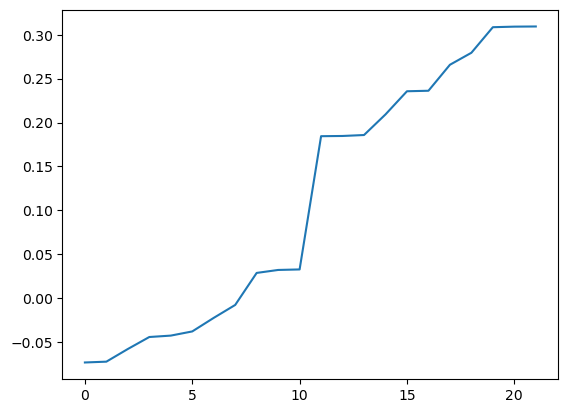

timestamp                  symbol
2022-09-23 06:00:00+00:00  ADA      -0.055556
                           ATOM     -0.055556
                           BTC       0.500000
                           DOT      -0.055556
                           ETC      -0.055556
                                       ...   
2022-11-22 06:00:00+00:00  ETH       0.095550
                           LINK     -0.160278
                           LTC      -0.094665
                           MATIC     0.016905
                           XRP      -0.103340
Name: position, Length: 14410, dtype: float32
['ADA', 'ATOM', 'BTC', 'DOT', 'ETC', 'ETH', 'LINK', 'LTC', 'MATIC', 'XRP']
test shift predict


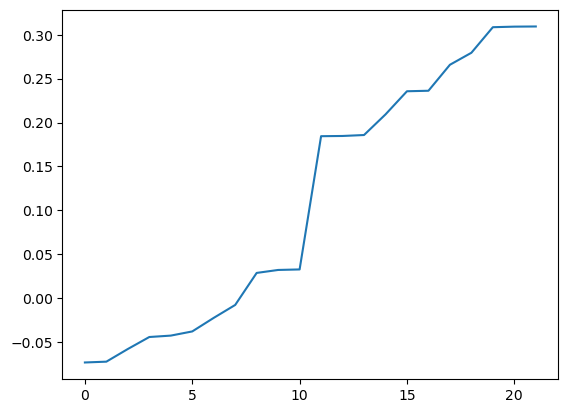

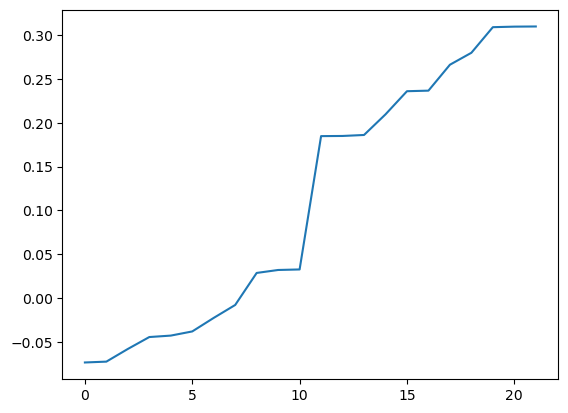

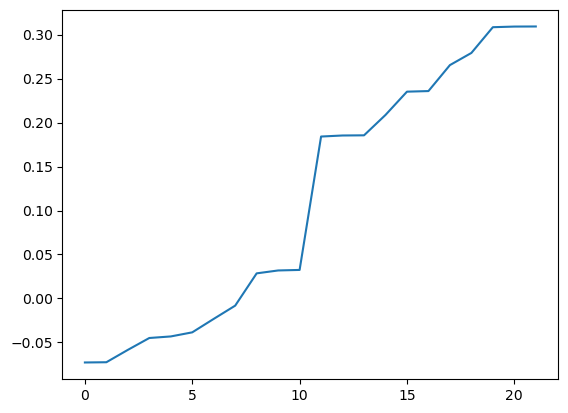

position1  position2  position3
timestamp                 symbol                                 
2022-09-23 07:00:00+00:00 ADA     -0.055556  -0.055556  -0.055556
                          ATOM    -0.055556  -0.055556  -0.055556
                          BTC      0.500000   0.500000   0.500000
                          DOT     -0.055556  -0.055556  -0.055556
                          ETC     -0.055556  -0.055556  -0.055556
...                                     ...        ...        ...
2022-11-22 05:00:00+00:00 ETH      0.067399   0.067399   0.067399
                          LINK    -0.060080  -0.060080  -0.060080
                          LTC     -0.059303  -0.059303  -0.059303
                          MATIC   -0.013194  -0.013194  -0.013194
                          XRP     -0.077565  -0.077565  -0.077565

[14390 rows x 3 columns]

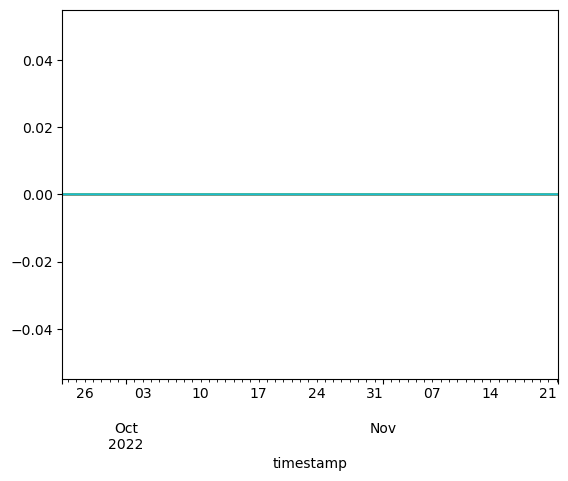

ADA (1439, 4)
ATOM (1439, 4)
BTC (1439, 4)
DOT (1439, 4)
ETC (1439, 4)
ETH (1439, 4)
LINK (1439, 4)
LTC (1439, 4)
MATIC (1439, 4)
XRP (1439, 4)


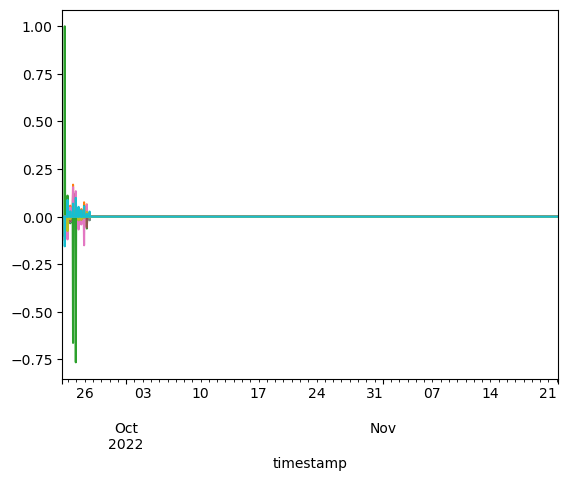

In [12]:
# model validation (Just run this cell in the new kernel to make sure you saved it in a portable format.)

import os
import joblib
import pandas as pd

model = joblib.load('/home/jovyan/data/{}.xz'.format(model_name))
df = pd.read_pickle('/tmp/df_binance_ohlcv_extended.pkl')
df = df[['op', 'hi', 'lo', 'cl', 'volume']]
max_timestamp = df.index.get_level_values('timestamp').max()
df = df.loc[max_timestamp - pd.to_timedelta(model.max_data_sec, unit='S') <= df.index.get_level_values('timestamp')]
print(model.predict(df))
print(model.symbols)



print('test shift predict')
import matplotlib.pyplot as plt

position1 = model.predict(df)
position2 = model.predict(df.loc[df.index.get_level_values('timestamp') < max_timestamp])
position3 = model.predict(df.loc[df.index.get_level_values('timestamp').min() < df.index.get_level_values('timestamp')])

test_timestamp = max_timestamp - pd.to_timedelta(1, unit='H')
df_test = pd.concat([
    position1.rename('position1'),
    position2.rename('position2'),
    position3.rename('position3'),
], axis=1)

df_test = df_test.dropna()
display(df_test)

for symbol, df_symbol in df_test.groupby('symbol'):
    df_symbol = df_symbol.reset_index().set_index('timestamp')
    (df_symbol['position2'] - df_symbol['position1']).plot()
plt.show()

for symbol, df_symbol in df_test.groupby('symbol'):
    df_symbol = df_symbol.reset_index().set_index('timestamp')
    print(symbol, df_symbol.shape)
    (df_symbol['position3'] - df_symbol['position1']).plot()
plt.show()